# TERCER NOTEBOOK - KMEANS COMO MÉTODO DE CLUSTERING PARA LA COLUMNA DE OBSERVACIONES

**Contenido**

1. Diseño del algoritmo 
2. Resultados ELBOW para encontrar el número óptimo de clusters
3. Ejecución del algoritmo Kmeans 
4. Gráfica de la cantidad de ordenes de trabajo (OT) por cluster encontrado

El objetivo de este tercer notebook es el diseño e implementación de un algoritmo basado en las distancias entre cada oración en la columna de observaciones, con el fin de agrupar (clustering) las oraciones con similar contenido y poder identificar patrones de comportamiento. 

# I. DISEÑO DEL ALGORITMO

#### Importar paquetes 

In [1]:
import collections
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pprint import pprint
import numpy as np
from string import punctuation
from time import time
import os
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()

#### Estructura del algoritmo

In [2]:
# Tokenizar palabras
def word_tokenizer(text):    
    tokens = word_tokenize(text)   # tokenizes and stems the text
    # non_words = list(punctuation)  # removes punctuation 
    # text = ''.join([c for c in text if c not in non_words]) ---> Data ingresada ya está libre de puntuación
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words] # Posibilidad de extender stopwords
    return tokens

In [3]:
# Número óptimo de clústers 1 - ELBOW
def elbow_method(sentences,figsize = (7,5),  namecol=None, nro_top=None, save = False,width_text = 0.81, height_text = 0.92):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    import warnings
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if len(sentences)<= 30:
                list_k = list(range(1,len(sentences)+1))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            elif len(sentences)> 30 and len(sentences)<= 70:
                list_k = list(range(2,len(sentences)+1,2))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)     

            else:     
                list_k = list(range(2,71,4))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)
            from kneed import KneeLocator
            kn = KneeLocator(list_k, elbow, curve='convex', direction='decreasing')
            print(f'Número óptimo de clústers: {kn.knee}') 
            plt.rcParams.update({'figure.figsize':figsize})
            plt.xlabel('Número de clusters k')
            plt.ylabel('Suma de distancias cuadradas')
            plt.plot(list_k, elbow, 'bo-')
            plt.title('Método del Elbow')
            plt.text(width_text, height_text, f'k óptimo: {kn.knee}', transform=plt.gca().transAxes)
            plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
            if save :
                plt.savefig(f'{namecol} {nro_top} - Método del elbow.jpg', dpi= 200, quality=95)
            plt.show()

    except ValueError:
        print('You must enter at least two sentences')

In [4]:
# Número óptimo de clústers 2 - Silhouette Analysis
def silhouette_plot(sentences, n_clusters, figsize=(9,5), width=1.02, height=0.96):
    fig, ax1 = plt.subplots(figsize=(9,5))
    #plt.rcParams.update({'figure.figsize':figsize})
    plt.rcParams.update({'figure.autolayout': True})
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    X_std = tfidf_vectorizer.fit_transform(sentences)

    # Run the Kmeans algorithm
    km = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 101)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Coeficientes de Silueta')
    ax1.set_ylabel('Clusters')
    ax1.set_title(f'Análisis de Silueta para k = {n_clusters}', y=1.02)
    plt.text(width, height, f'Silhouette Score: {round(avg_score,4)}', transform=plt.gca().transAxes);
    
def silhouette_analysis(sentences, n_clusters, save = True, name= None):
    for k in n_clusters:
        silhouette_plot(sentences,n_clusters=k)
        if save:
            plt.savefig(f'{name} - Silueta con k {k}.jpg', dpi= 200, quality=95)

In [5]:
# Algoritmo Kmeans
def cluster_sentences(sentences, nb_of_clusters):

    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    
    kmeans = KMeans(n_clusters = nb_of_clusters, init = 'k-means++', random_state = 101, max_iter=300)
    #kmeans.fit(tfidf_matrix)
    X_dist=kmeans.fit_transform(tfidf_matrix)**2  #Se calcula la distancia del cluster y se multiplica al cuadrado
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(i)

    Distancia=X_dist.sum(axis=1)  #Se calcula la distancia por columna de la matriz

    distDict={}  # Se traspasa a un diccionario con las distancias por cluster
    for key,val in clusters.items():
        distDict[key]=Distancia[val]

    representativos=[]   # Se guarda en una lista los valores mínimos de cada cluster (Menor distancia al centro mejor es el representativo)
    
    #Verificacion de los numeros de clusters
    #Si se intenta obtener los representativos de un número mas grande de cluster que el permitido, se procesa el número de clusters
    if len(distDict)<nb_of_clusters:
        nb_of_clusters=len(distDict)
        
    #Verificacion de los números de clústers
    for i in range(nb_of_clusters):
        representativos.append(np.where(distDict[i]==min(distDict[i]))[0][0])

    return dict(clusters),representativos

In [6]:
# Plot cantidad de sentences por cluster
def len_clusters(dic, n, namecol=None, nro_top=None, save = False, width = 0.6, color = "royalblue", figsize = (8,5)):
    keys = list(range(0,n))
    len_values = [len(dic[i]) for i in keys]
    plt.rcParams.update({'figure.figsize': figsize})
    plt.bar(keys,len_values , align='center', color = color, width = width)
    plt.title('Cantidad de OT por clúster')
    plt.xlabel('Clusters')
    plt.ylabel('Orden de Trabajo (OT)')
    plt.xticks(np.arange(min(keys), max(keys)+1, 1.0))
    if save:
        plt.savefig(f'{namecol} {nro_top} - Distribucion clusters .jpg', dpi= 200, quality=95)
    plt.show()

<div class="alert alert-success" style="margin: 20px">Para poder ejecutar correctamente los algoritmos de arribe, es necesario tener base de datos previamente limpia y en formato. Para más información ir al primer notebook, donde es aplicada la función word_cleaner().</div>

#### Importar Data Frame 

In [7]:
df_total = pd.read_pickle('../2. Topic Modeling - LDA 24 topics/BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_total.head()

Region                                           Estacion  \
0    13°                                       Tingaro Spa.   
1     8°                       Combustibles El Volcan Ltda.   
2    10°           LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.   
3     1°     Soc. Imp. y Exp. Nuevo Amanecer Ltda. (SOCIEX)   
4     3°  Inmobiliaria e Inversiones San José Ltda (Vall...   

               Tipo de Falla Prioridad Cliente  Estado OT Tecnico Asignado  \
0  Carrete RetractilOTROOTRO   Normal 48 Horas    CERRADA      Juan Aliaga   
1  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   
2  Carrete RetractilOTROOTRO   Normal 24 Horas  PRECIERRE   Luis Almonacid   
3  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   
4  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   

       Dia  Nro Dia     Mes  Hora Rango Recep/Arribo Rango Arribo/Cierre  \
0  Viernes       30  AGO 19    16    Error en fechas        Más de 1 mes   
1  Viernes       30  AGO 19    12    Error en fechas         Menos de 1h   
2  Viernes       30  AGO 19    12       0 a 24 horas         Menos de 1h   
3  Viernes       30  AGO 19    12       0 a 24 horas         Menos de 1h   
4  Viernes       30  AGO 19    12    Error en fechas         Menos de 1h   

                                         Observación  \
0  se cambia placa de tk 2 gas95 por placa que in...   
1  cambio de graficas de equipos no esta contempl...   
2  se visita eds para chequeo de dispensador el c...   
3  remplazo de graficas no esta contemplado en es...   
4  remplazo de graficas no esta contemplado en co...   

                                       Requerimiento  Topico Dominante  
0  area de atencion habilitar estanque de combust...                 2  
1  area de atencion combustible maria veronica go...                23  
2  area de atencion surtidor de diesel a ratos co...                 3  
3  area de atencion combustible cambiar graficas ...                 4  
4  area de atencion combustible solicita grafica ...                 4

# II. RESULTADOS DE KMEANS

## 1. TIPO DE FALLA

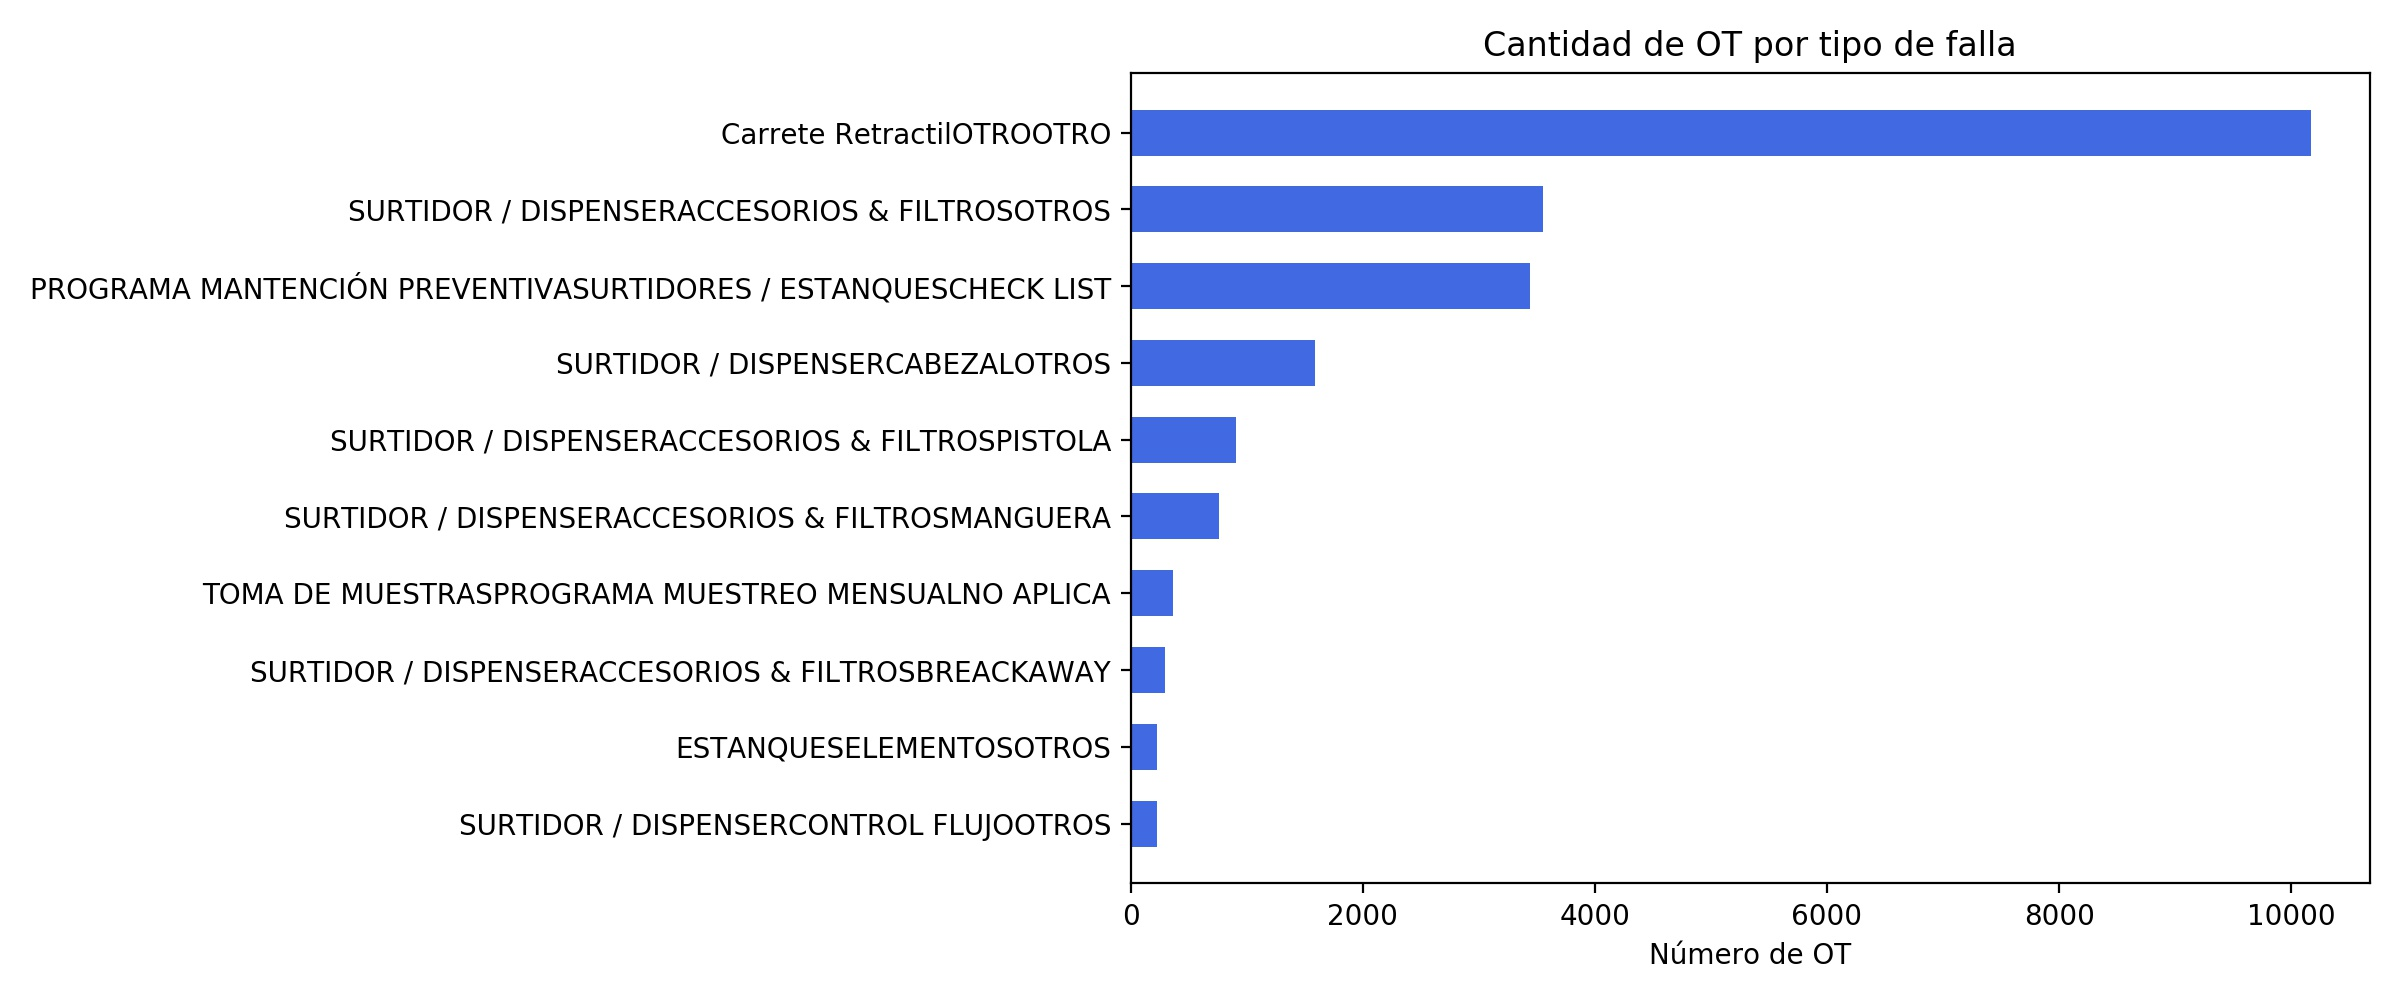

In [8]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/3) Tipo de falla.jpg',width=800, height=600)

In [9]:
# SELECCIONANDO UN TIPO DE FALLA EN PARTICULAR ('SURTIDOR / DISPENSERCABEZALOTROS')
df = df_total[df_total['Tipo de Falla'] == 'SURTIDOR / DISPENSERCABEZALOTROS'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1561

In [10]:
# Extracto obs tipo de falla
sentences[:2]

['se realiza el cambio de 1 motor monofasico 34 hp proporcionado por sercon quedando equipo operativo',
 'en dispensador 2 diesel se cambia orings de eje punta del medidor lo que mojaba el pulser y arrojaba error 2 0 se realizan pruebas y se verifica que no alla filtracion equipo queda 100 operativo ambas bocas en dispensador 2 diesel se cambia orings de eje punta del medidor lo que mojaba el pulser y arrojaba error 2 0 se realizan pruebas y se verifica que no alla filtracion equipo queda 100 operativo ambas bocas']

#### Ejecutar el algoritmo para un tipo de falla 

Número óptimo de clústers: 26


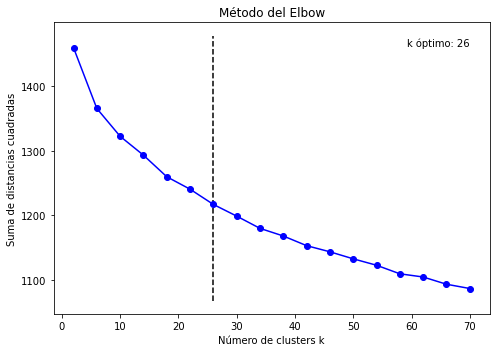

Wall time: 51.5 s


In [13]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Tipo de Falla', nro_top=4)

Wall time: 28.3 s


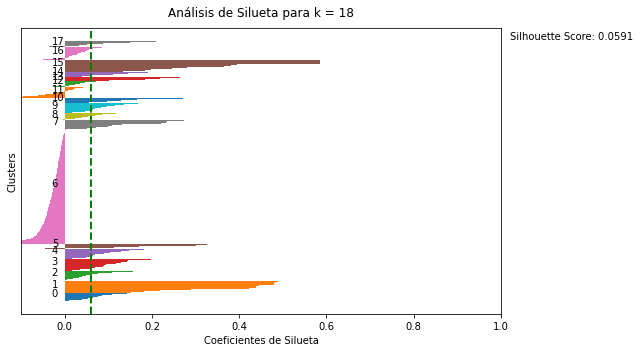

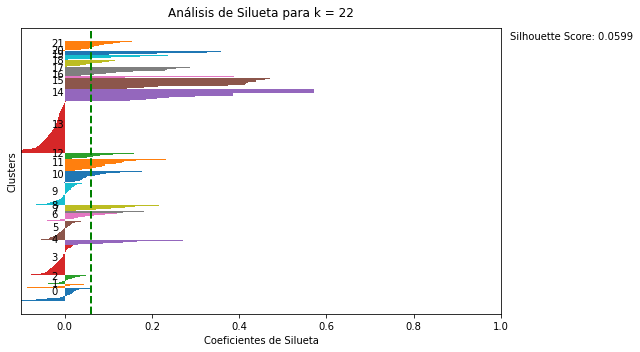

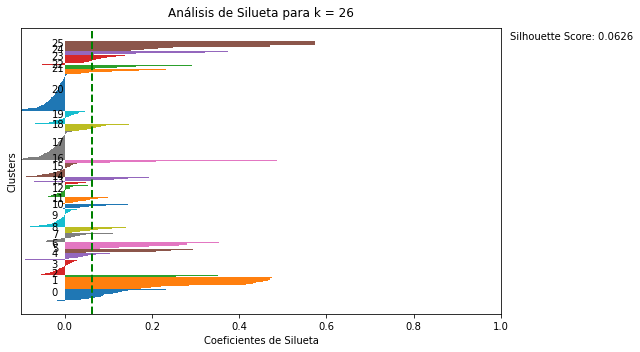

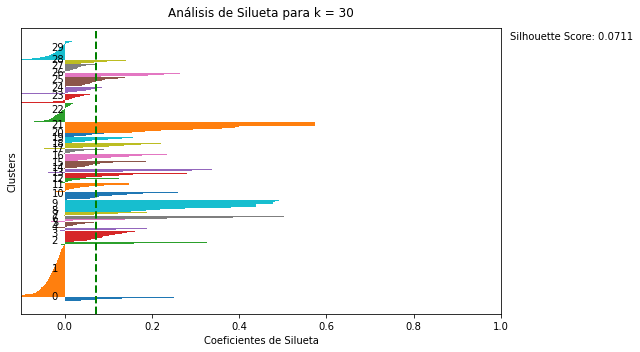

In [14]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[18,22,26,30], name='Tipo de Falla 4', save=True)

In [15]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza el cambio de 2 swivel 1 quedando equipo operativo
	sentence  0 :  swivel desvocado filtra cambio de swivel 34 a boca 7 de 97 el cual se desboco y filtra
	sentence  1 :  se realiza visita a estacion encontrando swivel con filtracion en boca 3 y 11 ambas de gas93 se procede al cambio de 2 swivel 34 quedando bocas operativas y sin filtracion se recircula producto para pruebas de funcionamiento se realiza visita a estacion encontrando swivel con filtracion en boca 3 y 11 ambas de gas93 se procede al cambio de 2 swivel 34 quedando bocas operativas y sin filtracion se recircula producto para pruebas de funcionamiento
	sentence  2 :  se realiza el cambio de 01 pistola 1 opw y 01 swivel 1 ya que ambos estaban en mal estado cambio fue por uso repuestos cambiado fuero dejados en punto industrial repuestos utilizados 01 pistola 1opw codigo repuesto p14781 01 swivel 1 opw codigo repuesto p15165 se realiza el cambio de 01 pistola 1 opw y 01 swivel 1 ya que ambos es

	sentence  4 :  se revisa dispensador doble de diesel lado 2 pistola no corta al llegar liquido al sensor en punta de pistola se cambia una pistola 7h y se recirculan litros para prueba queda funcionando normalmente modelo de pistola 7hb serie de la mala y 171837 de la nueva se revisa dispensador doble de diesel lado 2 pistola no corta al llegar liquido al sensor en punta de pistola se cambia una pistola 7h y se recirculan litros para prueba queda funcionando normalmente modelo de pistola 7hb serie de la mala y 171837 de la nueva
	sentence  5 :  se cambia 1 pistola 12 boca 3 95 sensor en mal estado quedando surtidor operativo y despachando producto 95 se cambia 1 pistola 12 boca 3 95 sensor en mal estado quedando surtidor operativo y despachando producto 95
	sentence  6 :  se cambia pistola 12 por encontrarse danada en baca 1 de gasolina 95 quedando con despacho normal se cambia pistola 12 por encontrarse danada en baca 1 de gasolina 95 quedando con despacho normal
	sentence  7 :  se r

	sentence  20 :  al momento de llegar a eds despacho de todos los productos es normal se revisa tablero electricovoltage de alimentacion consumo de todas las bombas sumergibles y se ajustan consumo maximo en reles termicos se realizan pruebas con preset y con ventases posible que en un momento el voltage externo presento variaciones muy bruscas pero luego se normalizo al momento de llegar a eds despacho de todos los productos es normal se revisa tablero electricovoltage de alimentacion consumo de todas las bombas sumergibles y se ajustan consumo maximo en reles termicos se realizan pruebas con preset y con ventases posible que en un momento el voltage externo presento variaciones muy bruscas pero luego se normalizo
	sentence  21 :  se visita eds encontrandose sin despacho de diesel se chequea tablero electrico encontrandose con condicion normal se chequea cabezal y linea electrica encontrandose con agua al interior de camara y linea electrica se retira agua de camaras se introduce aire

In [16]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza el cambio de 2 swivel 1 quedando equipo operativo
Cluster  1 : cambio de breakaway cortado a boca 1 de diesel mal uso equipo operativo
Cluster  2 : se realiza el cambio de 1 breackaway 1 quedando equipo operativo
Cluster  3 : se realiza el cambio de 1 valvula proporcional quedando equipo operativo
Cluster  4 : se realiza revison de equipo y accesorios colgantes encontrandose despacho venta cliente operativo
Cluster  5 : se realiza visita a estacion encontrando dispensador 1 y 2 con problemas de precorte se procede a cambiar parametros de configuracion quedando dispensadores operando con normalidad se observa funcionamiento con ventas a clientes sin presentar problemas en el despacho se realiza visita a estacion encontrando dispensador 1 y 2 con problemas de precorte se procede a cambiar parametros de configuracion quedando dispensadores operando con normalidad se observa funcionamiento con ventas a clientes sin presentar problemas en el despacho
Cluster  6 : se 

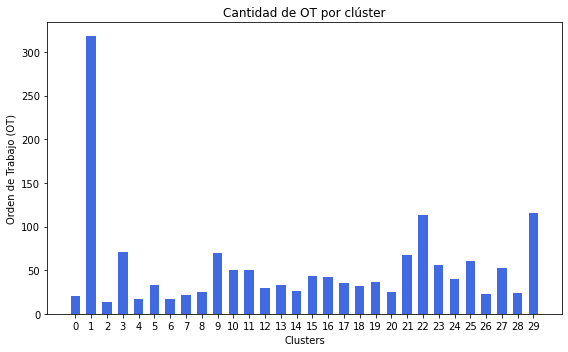

In [17]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Tipo de Falla', nro_top=4, figsize=(8,5)) 

## 2. ESTACIONES

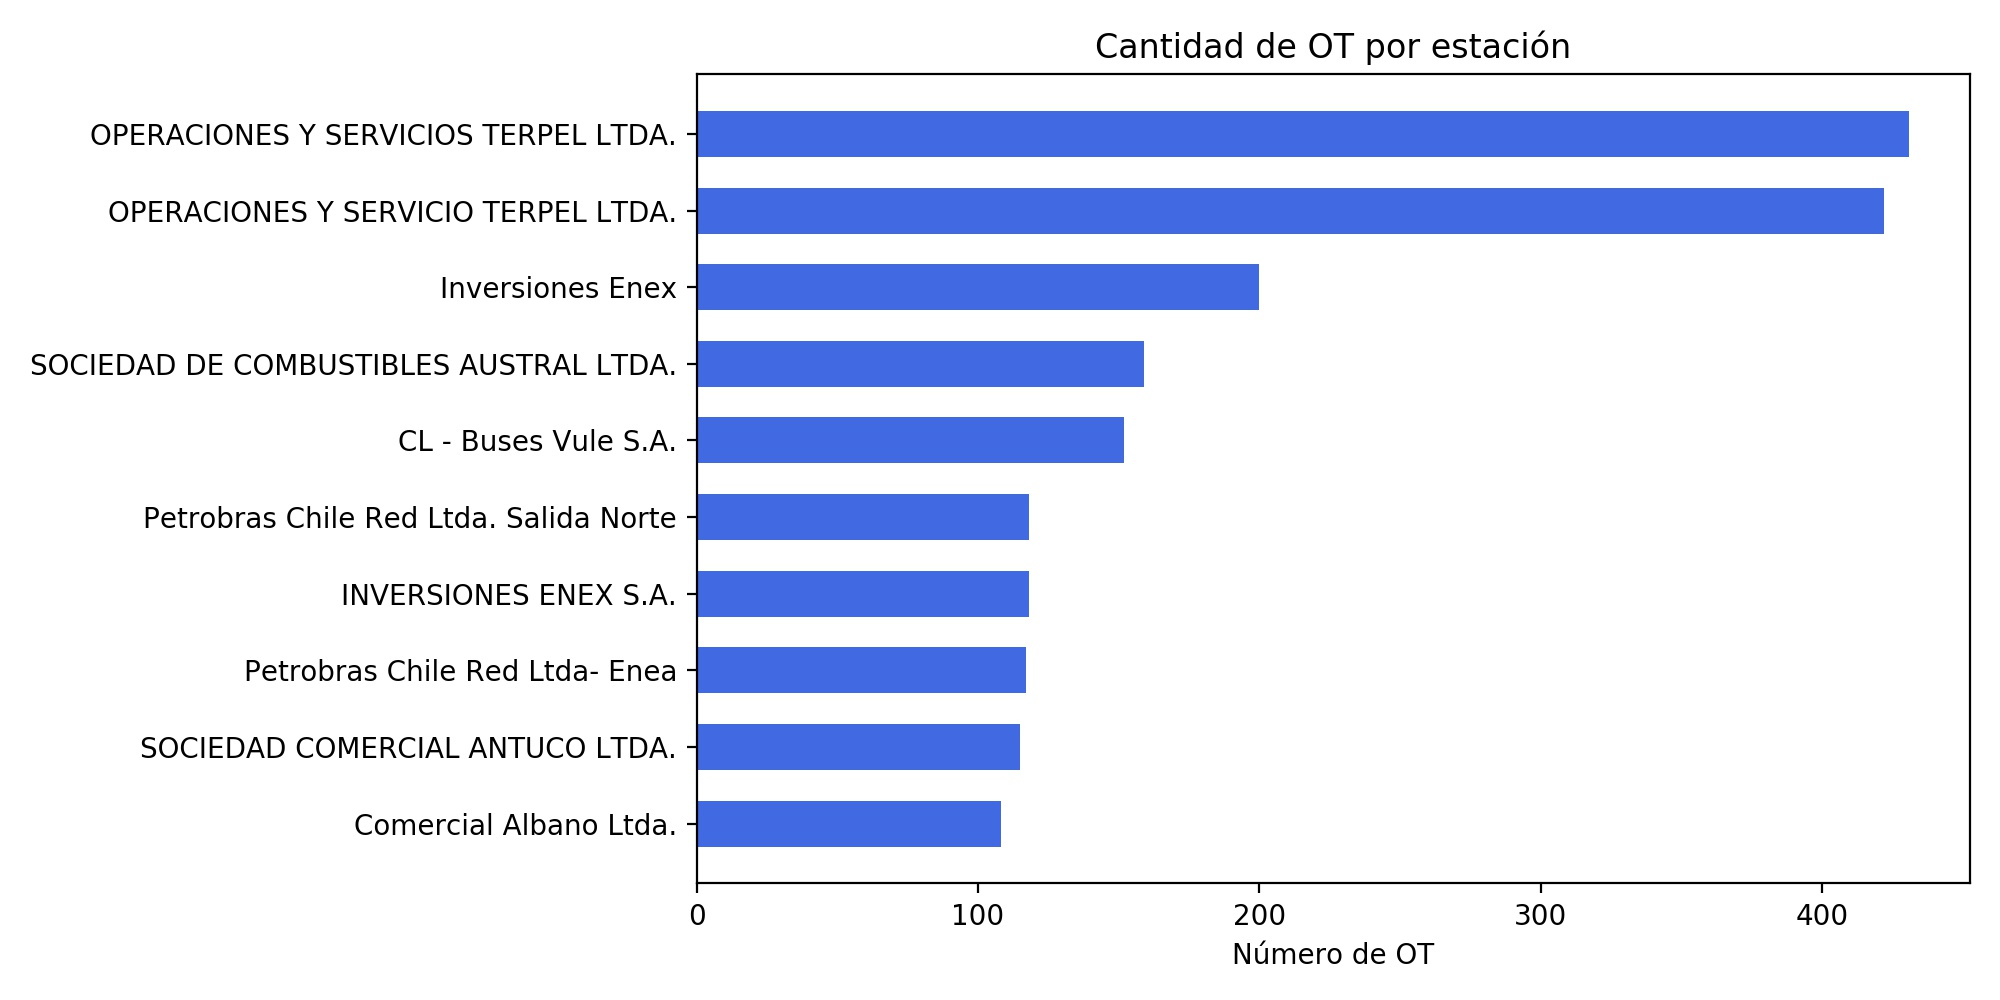

In [18]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/2) Estacion.jpg',width=700, height=500)

In [19]:
# SELECCIONANDO UNA ESTACIÓN ('OPERACIONES Y SERVICIOS TERPEL LTDA.')
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIOS TERPEL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

416

In [20]:
# Extracto obs estacion
sentences[:2]

['se chequea falla y se detecta ortirak que cuando le da el sol directo se borra por completo esto no permite el corrrecto uso del mismo se informa y solicita reparacion a empresa encargada se chequea falla y se detecta ortirak que cuando le da el sol directo se borra por completo esto no permite el corrrecto uso del mismo se informa y solicita reparacion a empresa encargada se niega firma por no estar reparado don marcelo olate',
 'en dispensador numero 7 producto 93 se detecto union manguera pistola suelta y con filtracion se reapreta union manguera pistola quedando operativa en dispensador numero 7 producto 93 se detecto union manguera pistola suelta y con filtracion se reapreta union manguera pistola quedando operativa']

#### Ejecutar el algoritmo para una estación

Número óptimo de clústers: 14


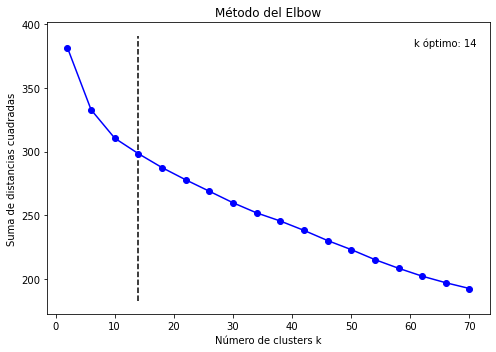

Wall time: 11.5 s


In [21]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Estacion', nro_top=1,  figsize=(7,5), width_text=0.83)

Wall time: 6.89 s


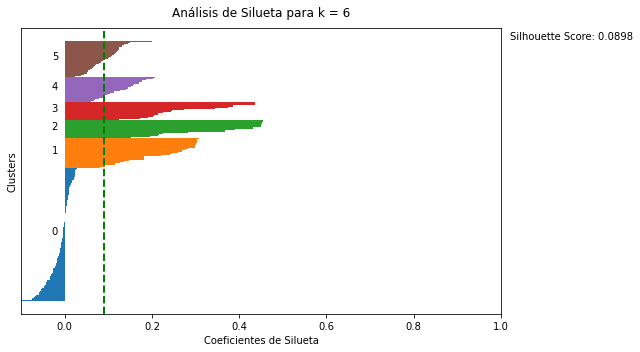

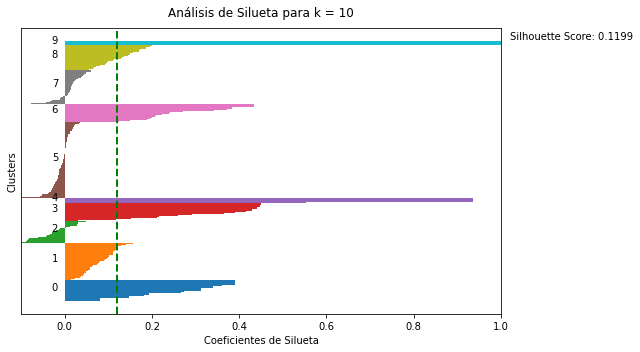

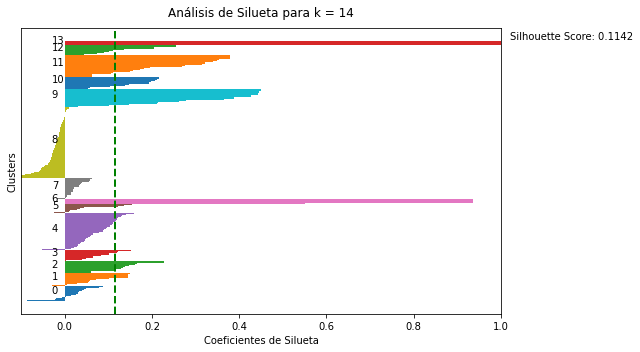

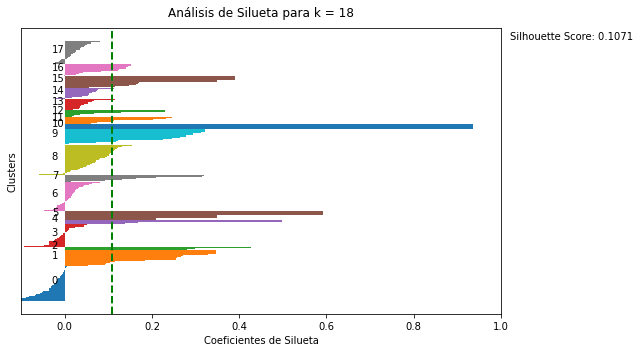

In [22]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[6,10,14,18], name='Estacion 1', save=True)

In [23]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=14
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza el cambio de 1 filtro spin on quedando equipo operativo
	sentence  0 :  se cambia tapa cano 4 de gas 93 quebrada queda operativa se cambia tapa cano 4 de gas 93 quebrada queda operativa se cambian accesorios en lado 1 de diesel pir filtraciones ademas tapa de 4 a spill descargas de gas93 quebrada queda pendiente el cambio de una tapa de 4 spill gas97 se hara a la brevedad posible se cambia tapa de cano 4 descarga rota gas97 queda operativa se cambia tapa cano 4 de gas 93 quebrada queda operativa se cambia tapa cano 4 de gas 93 quebrada queda operativa se cambian accesorios en lado 1 de diesel pir filtraciones ademas tapa de 4 a spill descargas de gas93 quebrada queda pendiente el cambio de una tapa de 4 spill gas97 se hara a la brevedad posible se cambia tapa de cano 4 descarga rota gas97 queda operativa
	sentence  1 :  se chequea falla y se detecta dispensadores lentos en diesel toda estacion se realiza verificacion detectando fuga interna se detecta 

In [24]:
# Clusters representativos (con n = 14)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza el cambio de 1 filtro spin on quedando equipo operativo
Cluster  1 : se realiza revison de equipo encontrandose despacho venta cliente operativo
Cluster  2 : se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos
Cluster  3 : se realiza mantenimiento preventivo a lados 12 34 y 5 se revisa cal

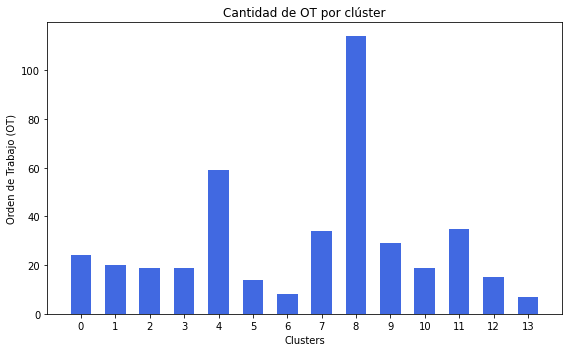

In [25]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Estacion', nro_top=1) 

## 3. TÉCNICOS ASIGNADOS

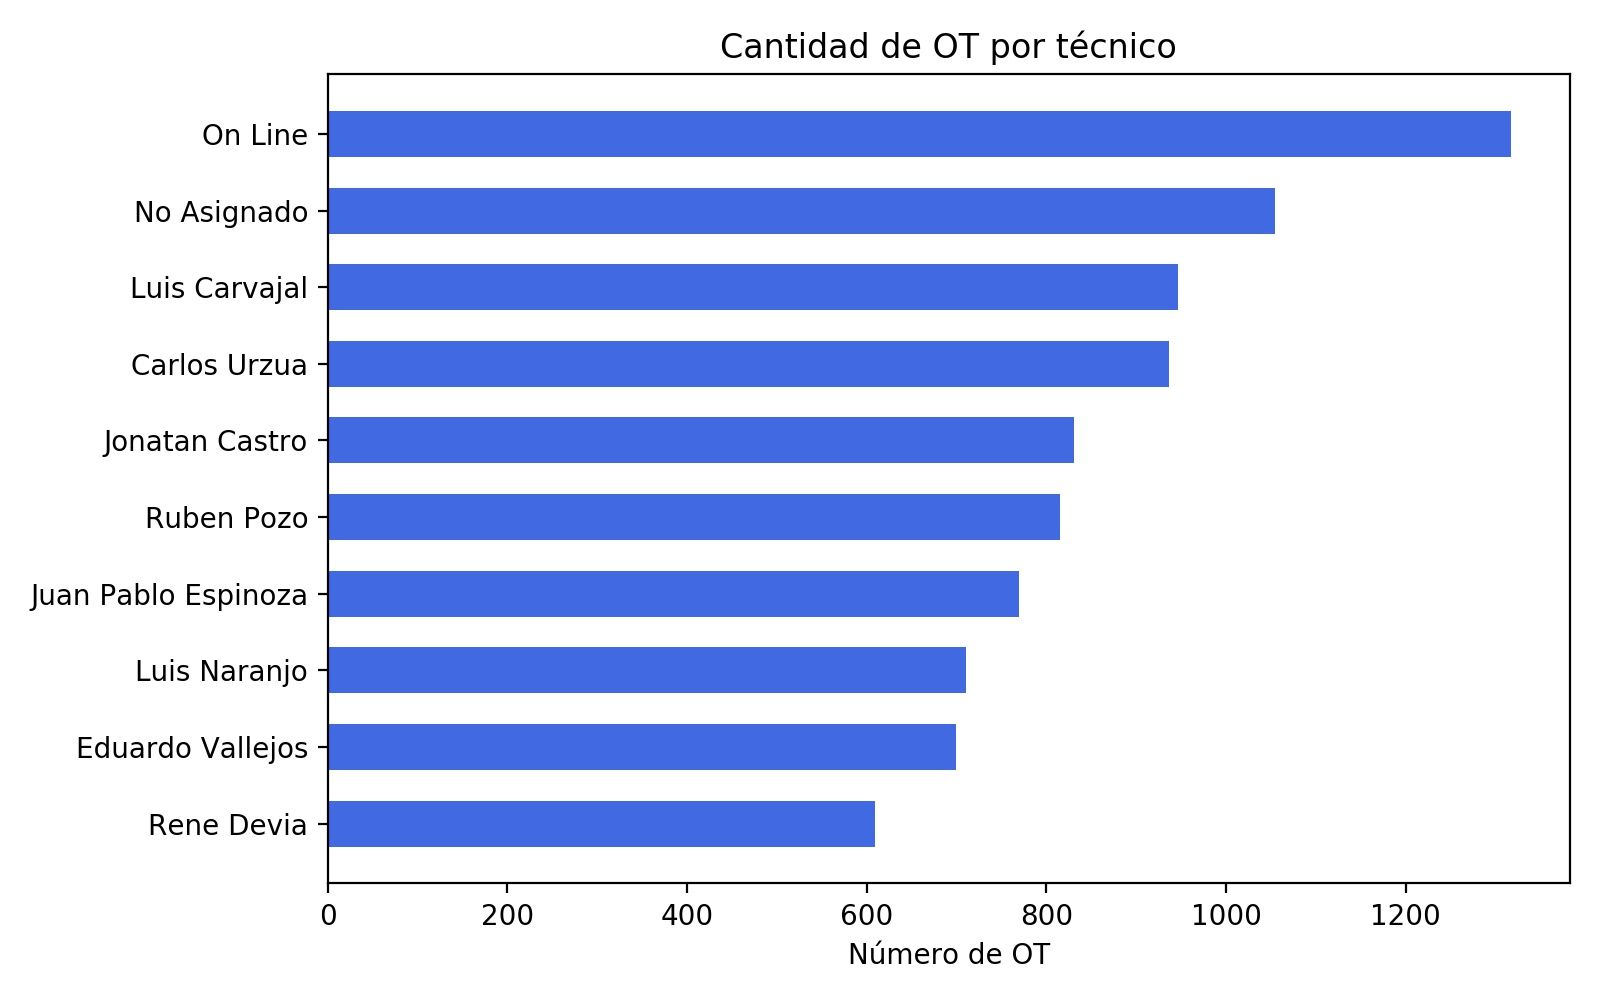

In [26]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/4) Tecnico asignado.jpg',width=600, height=400)

In [27]:
# SELECCIONANDO UN TECNICO ASIGNADO ('On Line')
df = df_total[df_total['Tecnico Asignado'] == 'On Line'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1302

In [28]:
# Extracto obs tecnico
sentences[:2]

['cambio de graficas de equipos no esta contemplado en estaciones delegadas',
 'remplazo de graficas no esta contemplado en estaciones delegadas']

#### Ejecutar el algoritmo para un técnico

Número óptimo de clústers: 22


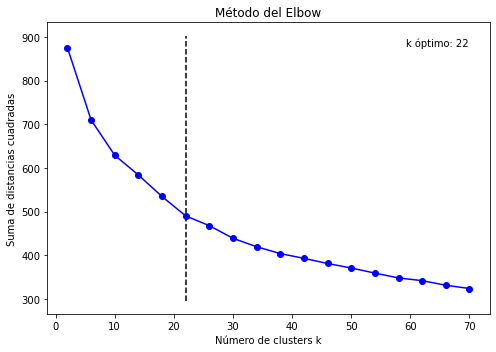

Wall time: 16.1 s


In [29]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Tecnico', nro_top=1)

Wall time: 12.5 s


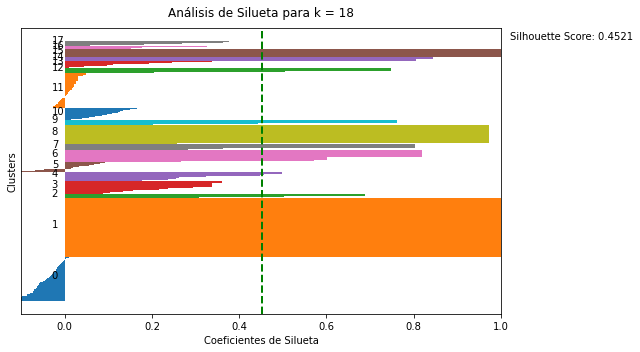

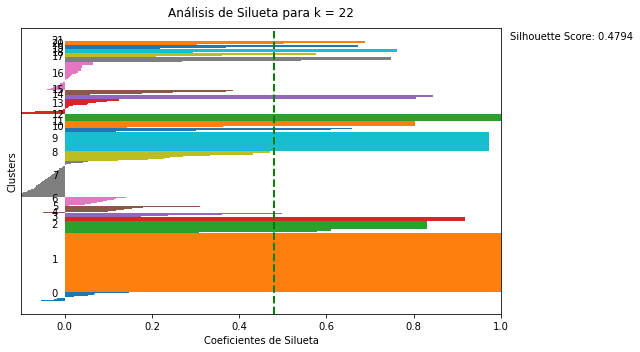

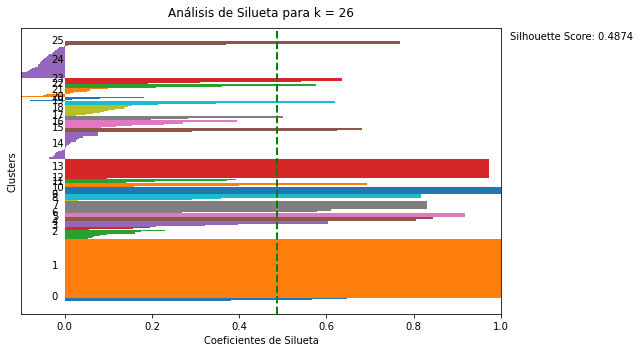

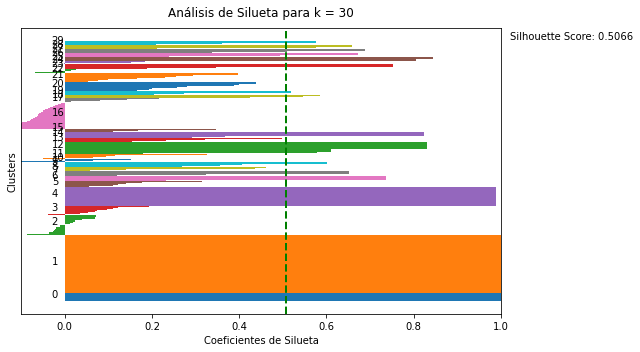

In [30]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[18,22,26,30], name='Tecnico 1', save=True)

In [31]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : duplicaron la ot incidencia sera atendida bajo la ot 19487
	sentence  0 :  incidencia sera vista mediante ot 28082
	sentence  1 :  incidencia debe ser atendida por estacion de servicio
	sentence  2 :  incidencia sera vista mediante ot 28082
	sentence  3 :  incidencia ha de ser atendida por personal de gilbarco
	sentence  4 :  incidencia debe ser atendida por estacion de servicio por ser mantencion delegada
	sentence  5 :  instlacion de brekaway debe ser realizada por estacion de servicio
	sentence  6 :  incidencia debe ser atendida por estacion de servicio por contar con mantencion delegada
	sentence  7 :  esta ot debe ser atendida por contratista a cargo de sistemas no combustible
	sentence  8 :  configuracion de horario de veeder r inicedencia debe ser derivada a gilbarco
	sentence  9 :  incidencia debe ser atendida por estacion de servicio
	sentence  10 :  incidencia debe ser atendida por estacion de servicio
	sentence  11 :  incidencia debe ser atendida por e

	sentence  122 :  os mal creada
	sentence  123 :  se adjunta cotizacion en plataforma 2611 a la espera de aprobacion se procede a dar cierre a ot ya que no fue aprobada por csim
	sentence  124 :  se realiza comunicacion telefonica con administrador quien comenta que el brazo de carga cuenta con funcionalidad sin problema a nivel mecanico se confirma que el problema se da con la comunicacion del sistema por lo cual el tema debe ser derivado a otro contratista genaro nunez informa al cliente y se da cierre online de ods
	sentence  125 :  mal asiganda
	sentence  126 :  incidencia es cerrada ya que punto queda inactivo de red enex
	sentence  127 :  se realiza cambio de tapa adptador de vapores
	sentence  128 :  se envia informacion a enex de levantamiento actualizado via correo electronico se procede a cierre de ods
	sentence  129 :  se toma contacto con administrador se regulariza venta via telefonica
	sentence  130 :  se converso via telefonica con administradora la cual menciona que est

	sentence  1 :  incidencia atendida y solucionada bajo la ot 5
	sentence  2 :  mp se realizara bajo la ot 5
	sentence  3 :  relacionada con la ot 5
	sentence  4 :  incidencia atendida bajo la mp ot 5
	sentence  5 :  incidencia atendida bajo ods 5
	sentence  6 :  incidencia atendida bajo ods 5
	sentence  7 :  incidencia es atendida bajo ot 5
	sentence  8 :  inciencia atendida bajo ods 5
	sentence  9 :  incidencia es atendida bajo ot 5
	sentence  10 :  incidencia es atendida bajo ot 5
	sentence  11 :  incidencia es atendida bajo ot 5
	sentence  12 :  incidencia es atendida bajo ot 5
	sentence  13 :  incidencia es atendida bajo ot 5
	sentence  14 :  incidencia es atendida bajo ot 5
	sentence  15 :  incidencia es atendida bajo ot 5
	sentence  16 :  incidencia es atendida bajo ot 5
	sentence  17 :  incidencia es atendida bajo ot 5
	sentence  18 :  se cierra bajo ot 5
Cluster 21 : incidencia atendida bajo la ot 9
	sentence  0 :  incidencia sera atendida bajo ot 9
	sentence  1 :  incidencia a

In [32]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : duplicaron la ot incidencia sera atendida bajo la ot 19487
Cluster  1 : ods mal emitida
Cluster  2 : incidencia mal asignada
Cluster  3 : incidencia se cierra ya que no corresponde a contrato combustibles
Cluster  4 : incidencia atendida bajo la ot 2
Cluster  5 : mantencion preventiva sera atendida bajo ot 1
Cluster  6 : incidencia sera atendida por estacion de servicio ya que corresponde a cambio de accesorio
Cluster  7 : ot fue atendida por contratista de enex
Cluster  8 : cliente reasigno incidencia ya que corresponde a otro contratista
Cluster  9 : incidencia mal emitida
Cluster  10 : ot periodo vencido incidencia atendida bajo ot 20175
Cluster  11 : se cierra por error de carga incidencia ya tenia ot
Cluster  12 : se cierra os ya que a partir de que se enlazaron los sistemas de sysqmr y csim se crearon os y ot automaticas duplicando las os de mp
Cluster  13 : incidencia no corresponde a sgs por lo tanto se cierra ot
Cluster  14 : ods mal ingresado
Cluster  15 : ot anu

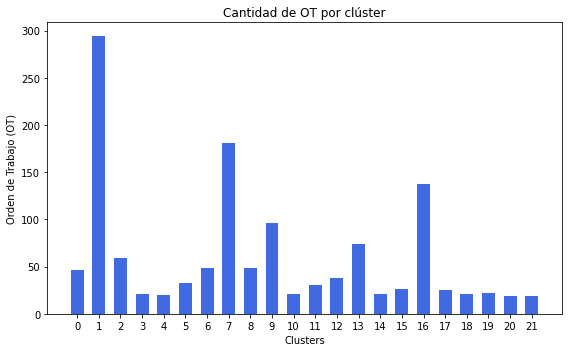

In [33]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Tecnico', nro_top=1) 

## 4. PRIORIDAD

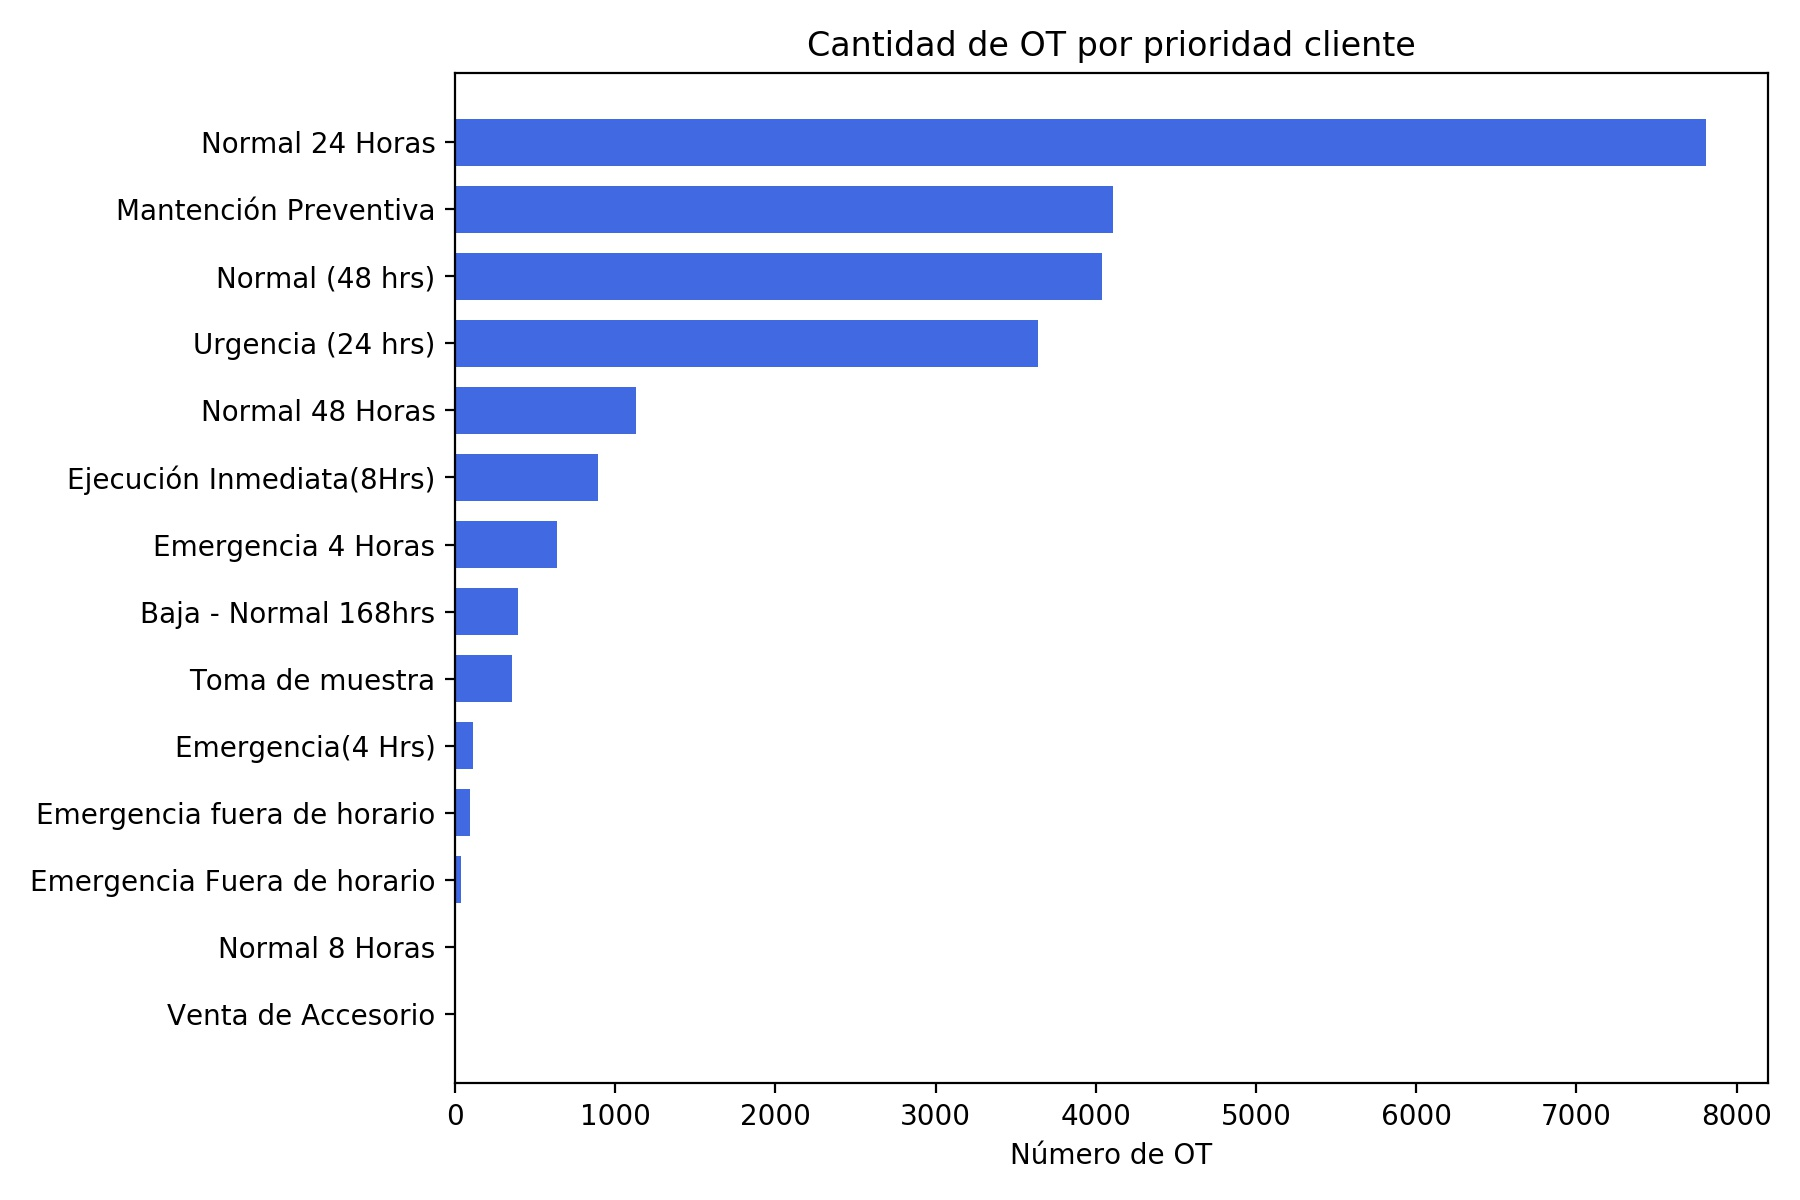

In [34]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/6) Prioriad cliente.jpg',width=600, height=500)

In [35]:
# SELECCIONANDO UNA PRIORIDAD ('Emergencia 4 Horas')
df = df_total[df_total['Prioridad Cliente'] == 'Emergencia 4 Horas'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

632

In [36]:
# Extracto obs prioridad
sentences[:2]

['se realiza mantencion correctiva en surtidor lado 5 el cual presentaba problemas en pistola la cual no despachada combustible se procede a cambiar accsesorio quedando en optimas condiciones de funcionamiento se realiza mantencion correctiva en surtidor lado 5 el cual presentaba problemas en pistola la cual no despachada combustible se procede a cambiar accsesorio quedando en optimas condiciones de funcionamiento',
 'en dispensador numero 1 se detecto y se cambio 01 pistola convencional de 1 con cano quebrado se recircula producto con ventas quedando operativa repuesto utilizado 01 pistola convenc de 1 p14781 en dispensador numero 1 se detecto y se cambio 01 pistola convencional de 1 con cano quebrado se recircula producto con ventas quedando operativa repuesto utilizado 01 pistola convenc de 1 p14781']

#### Ejecutar el algoritmo para una prioridad

Número óptimo de clústers: 30


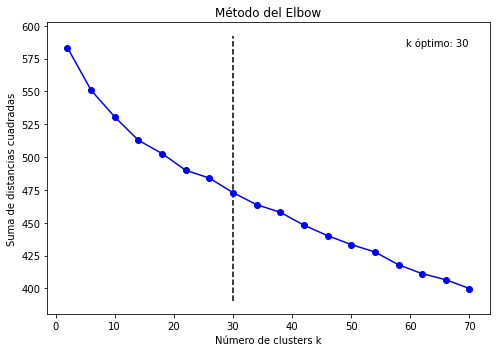

Wall time: 18 s


In [37]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Prioridad', nro_top=7)

Wall time: 8.3 s


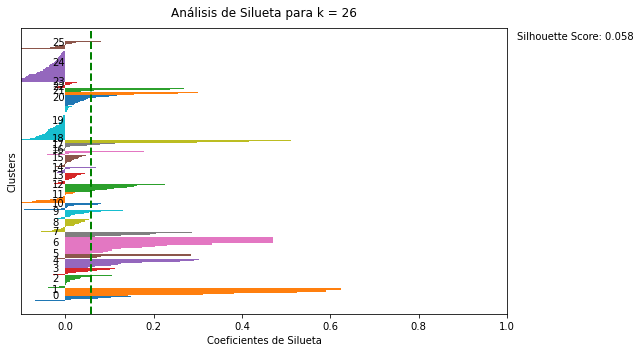

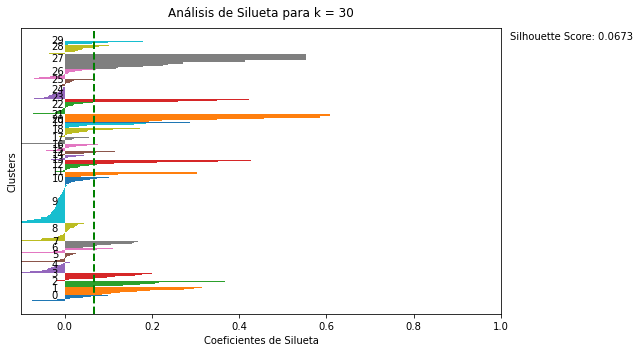

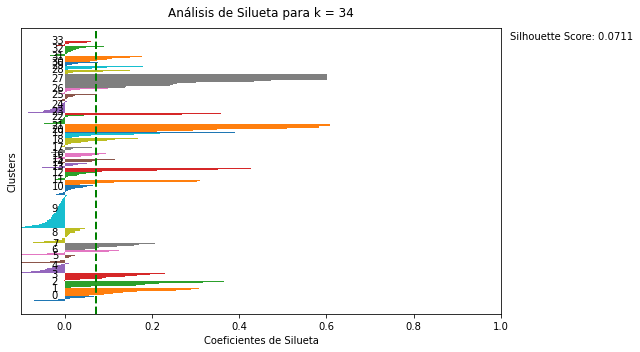

In [38]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[26,30,34], name='Tecnico 1', save=True)

In [39]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza el cambio de 1 correa wayne quedando equipo operativo
	sentence  0 :  se chequea falla y se reajusta correa suelta se prueba quedando operativa en un 100 se chequea falla y se reajusta correa suelta se prueba quedando operativa en un 100
	sentence  1 :  se chequea falla y se detecta problsma en diesel se reconecta quedando operativo en un 100 se chequea falla y se detecta problsma en diesel se reconecta quedando operativo en un 100
	sentence  2 :  se realiza reparacion y fijacion de portapistola ademas se reconecta breackaway quedando equipo operativo
	sentence  3 :  enen surtidor numero 4 se cambia 01 correa motor wayne y se reconecta breakaways de 34 convencional se realizan pruebas con preset quedando boca 100 operativa repuesto utilizado 01 correa plus v wayne p16374 surtidor numero 4 se cambia 01 correa motor wayne y se reconecta breakaways de 34 convencional se realizan pruebas con preset quedando boca 100 operativa repuesto utilizado 01 correa p

In [40]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza el cambio de 1 correa wayne quedando equipo operativo
Cluster  1 : incidencia es atendida bajo ot 2
Cluster  2 : se realiza el cambio de 2 filtros alta capacidad y 1 pistola 1 quedando equipo operativo
Cluster  3 : se realiza el cambio de 1 placa barrera intrinsica y 1 valvula bajo flujo quedando equipo despacho venta cliente operativo
Cluster  4 : en surtidor numero 2 se detecto y se cambio 01 pistola convencional de 1 con sensor malo se realizan pruebas quedando operativa en surtidor numero 2 se detecto y se cambio 01 pistola convencional de 1 con sensor malo se realizan pruebas quedando operativa
Cluster  5 : se realiza el cambio de 1 elemento funcional y 1 valvula retencion check quedando equipo operativo
Cluster  6 : se realiza el cambio de 1 pulser quedando equipo operativo
Cluster  7 : se realiza el cambio de 1 valvula de impacto 2 1 flexible electrico 2 tapas de medidor 2 oring tapa medidor 1 porta pistola 2 codos 34 compra quedando equipo ok
Cluster  8 

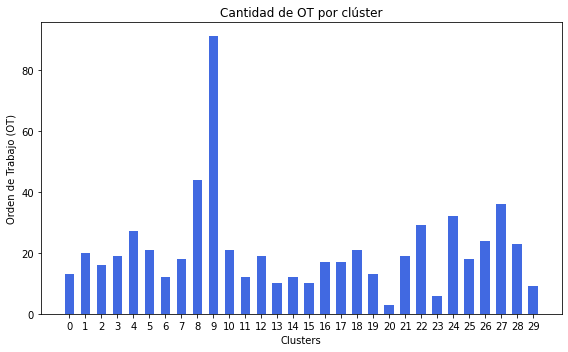

In [41]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Prioridad', nro_top=7) 

## 5. ESTADO OT 

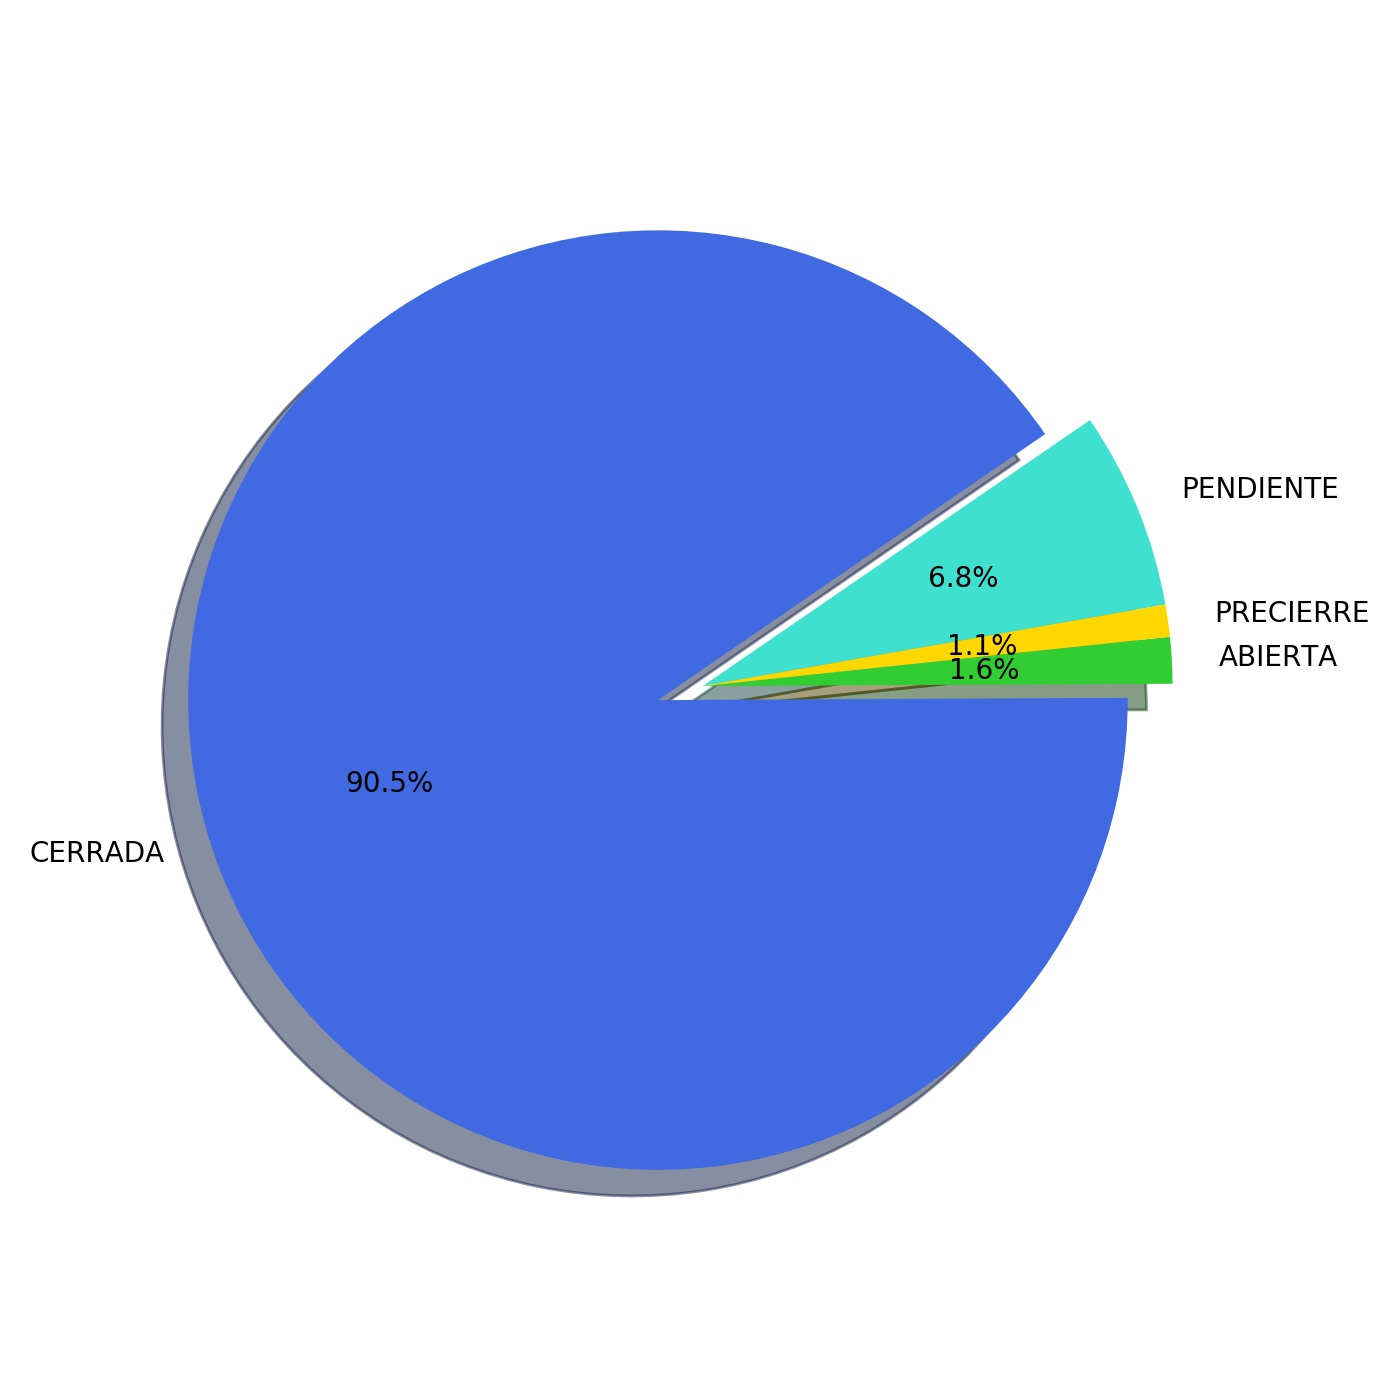

In [42]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/5) Estado OT.jpg',width=400, height=400)

In [43]:
# SELECCIONANDO UN ESTADO OT ('PENDIENTE')
df = df_total[df_total['Estado OT'] == 'PENDIENTE'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1128

In [44]:
# Extracto obs estado ot
sentences[:2]

['kadshjadsjsakjlskjlsajkshshadsdeqwriqweuibuci', 'eds fuera de contrato']

#### Ejecutar el algoritmo para un estado OT

Número óptimo de clústers: 18


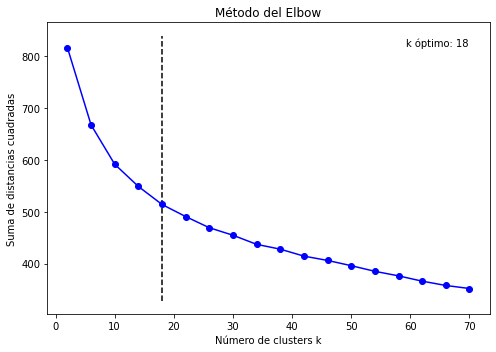

Wall time: 25.7 s


In [45]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,  save = True, namecol='Estado OT', nro_top='Pendiente')

Wall time: 12.2 s


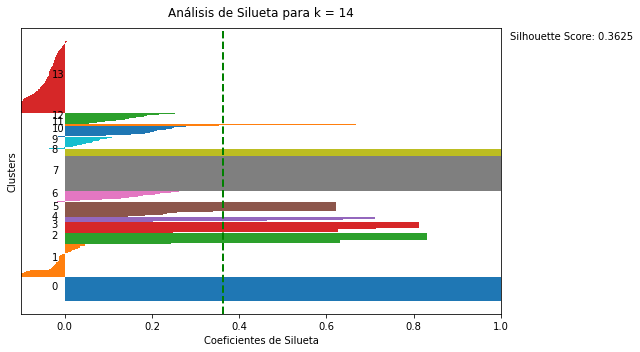

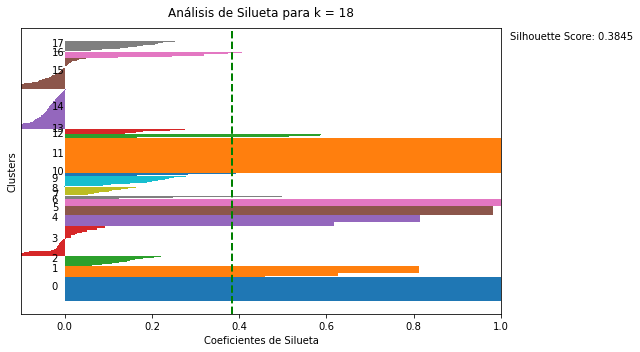

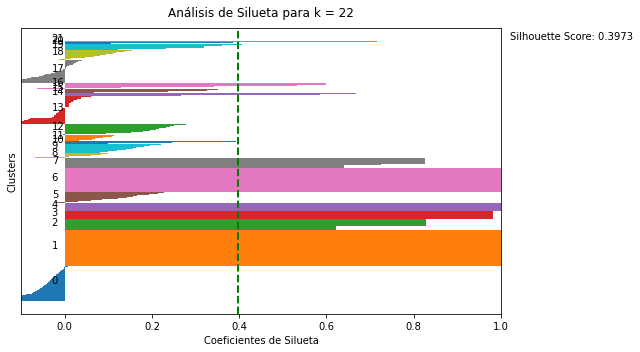

In [46]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[14,18,22], name='Estado OT Pendiente', save=True)

In [47]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=18
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : os mal emitida
	sentence  0 :  os mal emitida
	sentence  1 :  os mal emitida
	sentence  2 :  os mal emitida
	sentence  3 :  os mal emitida
	sentence  4 :  os mal emitida
	sentence  5 :  os mal emitida
	sentence  6 :  os mal emitida
	sentence  7 :  os mal emitida
	sentence  8 :  os mal emitida
	sentence  9 :  os mal emitida
	sentence  10 :  os mal emitida
	sentence  11 :  os mal emitida
	sentence  12 :  os mal emitida
	sentence  13 :  os mal emitida
	sentence  14 :  os mal emitida
	sentence  15 :  os mal emitida
	sentence  16 :  os mal emitida
	sentence  17 :  os mal emitida
	sentence  18 :  os mal emitida
	sentence  19 :  os mal emitida
	sentence  20 :  os mal emitida
	sentence  21 :  os mal emitida
	sentence  22 :  os mal emitida
	sentence  23 :  os mal emitida
	sentence  24 :  os mal emitida
	sentence  25 :  os mal emitida
	sentence  26 :  os mal emitida
	sentence  27 :  os mal emitida
	sentence  28 :  os mal emitida
	sentence  29 :  os mal emitida
	sentence  3

	sentence  8 :  se realiza calibracion a 03 dispensadores los cuales se encuentran dentro rango permitido se chequean accesoerios colgante limpieza pintado tapas spill se realiza calibracion a 03 dispensadores los cuales se encuentran dentro rango permitido se chequean accesoerios colgante limpieza pintado tapas spill
	sentence  9 :  se asiste a estacion y se realiza calibracion a 02 dispensadores los cuales se encuentra dentro rango permitido se chequean accesorios colgantes limpieza pintado tapa spill se asiste a estacion y se realiza calibracion a 02 dispensadores los cuales se encuentra dentro rango permitido se chequean accesorios colgantes limpieza pintado tapa spill
	sentence  10 :  mantencion preventiva se calibran 32 de 32
	sentence  11 :  se realiza calibracion a 01 un surtidor el cual se encuentra dentro rango permitido se chequean accesirio colgante limpieza pintado tapas spill se realiza calibracion a 01 un surtidor el cual se encuentra dentro rango permitido se chequean a

In [48]:
# Clusters representativos (con n = 18)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : os mal emitida
Cluster  1 : se realiza mantencion preventiva se calibran 2 bocas
Cluster  2 : 34 de 34 sin observaciones 34 de 34 se realiza calibracion de dispensadores 1 2 3 4 con un total de 16 bocas calibradas se chequean fugas interior y exterior se chequea y revisan camaras sump se chequea tdf se limpian spill container se realiza calibracion de dispensadores 5 6 7 8 9 y 10 con un total de 18 bocas calibradas total boca calibradas 34 de 34 que cuenta la estacion se te chequean fugas interior y exterior se pintan tapas de descarga se limpian dispensadores interior se finaliza mantencion preventiva con un total de 34 bocas calibradas estacion libre de fuga de combustible y agua en estanque
Cluster  3 : se realiza mantencion preventiva se calibran 34 bocas
Cluster  4 : se realiza mantencion preventiva se calibran 1 boca
Cluster  5 : mantencion preventiva mes de agosto solo calibracion
Cluster  6 : certificacion srv
Cluster  7 : se realiza mantencion preventiva correspon

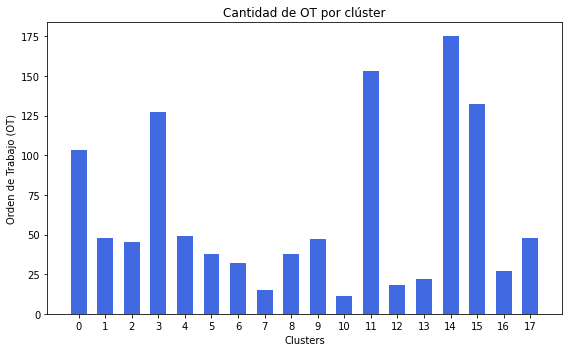

In [49]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Estado OT', nro_top='Pendiente') 

# TESTS 

## Prueba con el dataset de sentences más largo (cerca de 10.000) - Tipo de falla

In [50]:
# SELECCIONANDO UN TIPO DE FALLA EN PARTICULAR 
df = df_total[df_total['Tipo de Falla'] == 'Carrete RetractilOTROOTRO'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

9324

Número óptimo de clústers: 26


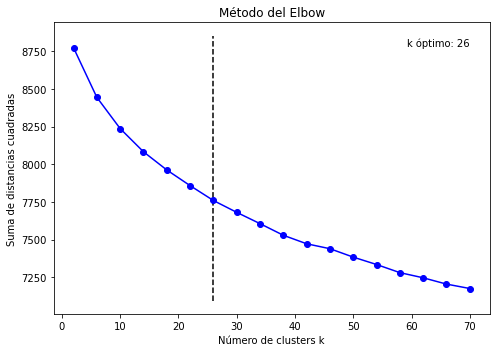

Wall time: 8min 15s


In [51]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Tipo de Falla', nro_top=1)

Wall time: 2min 39s


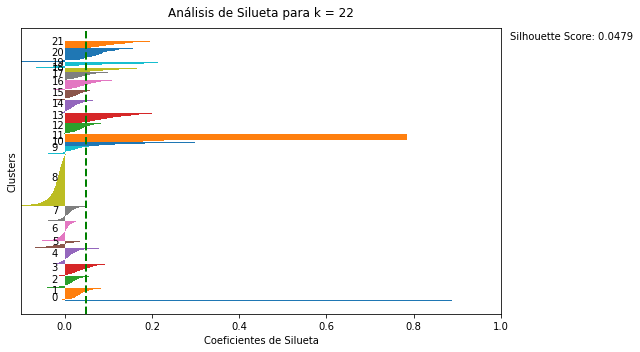

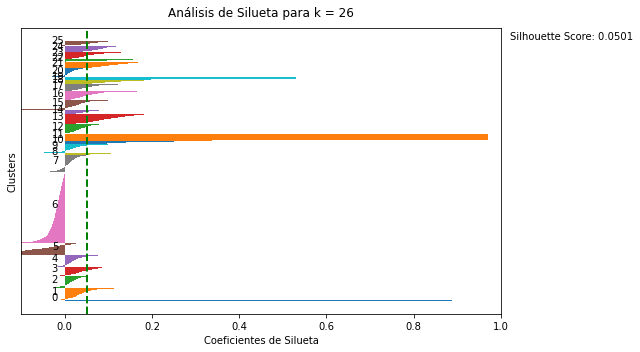

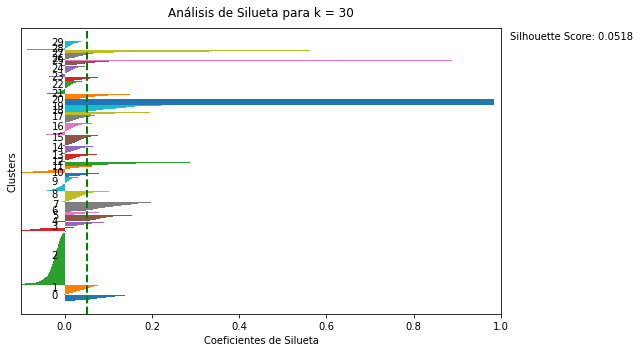

In [52]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[22,26,30], name='Tipo de Falla 1', save=True)

In [53]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza certificacion srv queda pendiente certificacion del lecse realizan pruebas de aire liquido en conjunto con personal del lec aprobando todos los dispenser se cambian filtros por flujo lento al momento de pruebas
	sentence  0 :  certificacion srv
	sentence  1 :  certificacion srv
	sentence  2 :  certificacion srv
	sentence  3 :  certificacion srv
	sentence  4 :  certificacion srv
	sentence  5 :  certificacion srv
	sentence  6 :  certificacion srv
	sentence  7 :  certificacion srv
	sentence  8 :  certificacion srv
	sentence  9 :  certificacion srv
	sentence  10 :  certificacion srv
	sentence  11 :  certificacion srv
	sentence  12 :  certificacion srv
	sentence  13 :  certificacion srv
	sentence  14 :  certificacion srv
	sentence  15 :  certificacion srv
	sentence  16 :  certificacion srv
	sentence  17 :  certificacion srv
	sentence  18 :  certificacion srv
	sentence  19 :  certificacion srv
	sentence  20 :  certificacion srv
	sentence  21 :  certificacion

	sentence  247 :  se solicita valvula de despiche emco para ser cambiada en spill contaiment de 97 se solicita bota dimension para ser cambiada en dispensador numero 2 de diesel se realiza el cambio de 1 valvula de drenaje emco wheatom p14411 en spill comtaiment de estanque de producto 97 y 1 bota pistola dimension p13383 en dispensador numero 2 de producto diesel quedando operativo se solicita valvula de despiche emco para ser cambiada en spill contaiment de 97 se solicita bota dimension para ser cambiada en dispensador numero 2 de diesel se realiza el cambio de 1 valvula de drenaje emco wheatom p14411 en spill comtaiment de estanque de producto 97 y 1 bota pistola dimension p13383 en dispensador numero 2 de producto diesel quedando operativo
	sentence  248 :  indican que clientes han efectuado diversos reclamos por el despacho de producto gas 93 en el dispensador no1 en donde indican de que este no entrega los litros correspondientes se verifica calibracion del dispensador tomando 03

	sentence  112 :  se realiza chequeo a equipo detectando falla en switch de menbrana selectora de producto se realiza cambio de 1 switch de menbrana a equipo boca n1 producto 93 se realuzan pruebas equipo operativo se realiza chequeo a equipo detectando falla en switch de menbrana selectora de producto se realiza cambio de 1 switch de menbrana a equipo boca n1 producto 93 se realuzan pruebas equipo operativo
	sentence  113 :  se observa flujo lento en producto 93 y 95 en 02 equipos b7c encontrandose filtros saturados producto 93 equipo mezclador se requiere cambio se comunica a encargada equipos corta antes de venta programada se observa flujo lento en producto 93 y 95 en 02 equipos b7c encontrandose filtros saturados producto 93 equipo mezclador se requiere cambio se comunica a encargada equipos corta antes de venta programada
	sentence  114 :  se realiza chequeo a equipo lado n3 se realizan pruebas de recirculacion dd producto no presentando falla se solicita repuesto pulser encore s

	sentence  296 :  programa mantencion preventiva mes junio 2019 calibracion verificacion detector de fuga estacion no cuenta con un sistema de deteccion de liquido en dispenser sump y tank sump cables y sensores programa mantencion preventiva mes junio 2019 calibracion verificacion detector de fuga se realiza mantencion preventiva verificacion volumetrica y calibracion revision de flujo chequeo de equipos pruebas de funcionamiento de detectores de fuga mecanicos extraccion de liquido de dispenser sump limpieaza de dispenser sump chequeo limpieza de camaras
	sentence  297 :  mantenciojn preventiva de mes de febrero se calibran un total de 13 bocas
	sentence  298 :  se realiza mantencion preventiva mes de abril se calibran un total de 13 bocas
	sentence  299 :  programa mantencion preventiva mes marzo 2019 se realiza mantencion preventiva se realiza cambio de filtros pistola y destorcedor se realiza verificacion volumetrica queda pendiente revision de detectores de fuga se realizan prueb

	sentence  623 :  se detecta falla en spill container opw este tiene una rotura entre la base de despiche y raiser se solicita cambio de contenedor producto 97 opw se adjunta cotizacion en plataforma a la espera de aprobacion
	sentence  624 :  se acude por variaciones en est de diesel segun informacion de encargada la falla se presenta en sistema la cual sera reparada por gilbarco se acude por variaciones en est de diesel segun informacion de encargada la falla se presenta en sistema la cual sera reparada por gilbarco
	sentence  625 :  se procede a enderezar faldon de disp 1 el cual se encontraba torcido por haber sido topado por vehiculo quedando ok se procede a enderezar faldon de disp 1 el cual se encontraba torcido por haber sido topado por vehiculo quedando ok
	sentence  626 :  canalizacion electrica defectuosa corresponde a focos de iluminacion de estacion canopi se debe llamar a contratista electrico para su reparacion canalizacion electrica defectuosa corresponde a focos de ilu

	sentence  1373 :  en dispensadores numeros 1 y 2 3 y 4 se reprograman funcion 22 subfuncion 03 se debe actualizar version de software en ambos dispensadores falla se viene presentando hace un tiempo en dispensadores numeros 1 y 2 3 y 4 se reprograman funcion 22 subfuncion 03 se debe actualizar version de software en ambos dispensadores falla se viene presentando hace un tiempo
	sentence  1374 :  se revisan todos las descarga de tanques de cl tk 12345 encontrandose con su placa de identificacion respectiva y datos correspondientes se revisan todos las descarga de tanques de cl tk 12345 encontrandose con su placa de identificacion respectiva y datos correspondientes
	sentence  1375 :  cambio de relay de fuerza motor a surtidor n 1 de gasolina 97 y 2 de gasolina 93 por no descononectar motor al momento de bajar palanca de accionamiento equipos quedan operativos cambio de relay de fuerza motor a surtidor n 1 de gasolina 97 y 2 de gasolina 93 por no descononectar motor al momento de bajar 

	sentence  2123 :  se llega al punto encontrandose todas las maquinas en buen estado todo operativo se llega al punto encontrandose todas las maquinas en buen estado todo operativo
	sentence  2124 :  se realizan inspeccion a dispensador 3 y 4 el cual presenta problemas al despachar combustible se realizan pruebas de recirculacion de producto gas 93 y 95 las cuales se encuentran despachando 30 ltr x minuto aprox no ee observan fallas al momento de despachar combustible se realizan inspeccion a dispensador 3 y 4 el cual presenta problemas al despachar combustible se realizan pruebas de recirculacion de producto gas 93 y 95 las cuales se encuentran despachando 30 ltr x minuto aprox no ee observan fallas al momento de despachar combustible
	sentence  2125 :  se revisa surtidores 5678 los cuales no funcionaban boton de seleccion de producto se detecta conector en display desconectado el cual corresponde a botones se conecta y queda operativo se realiza mantencion a back light y display de s

	sentence  314 :  se deja sin cambio de manguera gas 93 el cual mantiene la malla a la vista se realiza cambio de manguera en dispensador isla 3 cara 5 gas 93 que mantenia mallas a la vista queda funcionando se deja sin cambio de manguera gas 93 el cual mantiene la malla a la vista se realiza cambio de manguera en dispensador isla 3 cara 5 gas 93 que mantenia mallas a la vista queda funcionando
	sentence  315 :  se realiza visita a estacion encontrando breakaway cortado en boca 13diesel se procede al cambio de este quedando boca operativa se recircula producto para pruebas de funcionamiento se realiza visita a estacion encontrando breakaway cortado en boca 13diesel se procede al cambio de este quedando boca operativa se recircula producto para pruebas de funcionamiento
	sentence  316 :  se reapreta pistola union swivel y manguera lado 1 97 por filtracion de producto se recircula producto quedando dispensador operativo y sin filtracion se reapreta pistola union swivel y manguera lado 1 

	sentence  80 :  requerimiento no corresponde a contrato sgs
	sentence  81 :  requerimiento no corresponde a contrato sgs
	sentence  82 :  eds fuera de contrato
	sentence  83 :  incidencia no corresponde al contrato combustibles
	sentence  84 :  incidencia no corresponde a contrato sgs
	sentence  85 :  incidencia no corresponde al alcance de los servicios de sgs agradecere derivar a contratista correspondiente
	sentence  86 :  incidencia no corresponde a los servicios de sgs agradecere direccionar a contratista adecuado
	sentence  87 :  incidencia no corresponde a sgs
	sentence  88 :  punto industrial esta fuera de contrato
	sentence  89 :  incidencia se cierra por que estacion es contrato codo y no aplica el reemplazo de graficas
	sentence  90 :  incidencia corresponde a orpak
	sentence  91 :  incidencia reasignada a otro contratista
	sentence  92 :  fuera de contrato
	sentence  93 :  fuera de contrato se anula
	sentence  94 :  incidencia no corresponde a sgs tiene que verse con perso

	sentence  89 :  se realiza visita a estacion procediendo a retirar 50 litros de agua desde tk3diesel estanque queda sin agua se realiza visita a estacion procediendo a retirar 50 litros de agua desde tk3diesel estanque queda sin agua
	sentence  90 :  se retiran 200 litros de agua aproximadamente de estanque 2 de 97 la cual queda almacenanda en tambores se retiran 200 litros de agua aproximadamente de estanque 2 de 97 la cual queda almacenanda en tambores
	sentence  91 :  se visita estacion de servicio para realizar retiro de agua en el estanque de gasolina 93 y 97 agua retirada queda almacenada en tambores en estacion de servicio otcerrada se adjunta fotos se visita estacion de servicio para realizar retiro de agua en el estanque de gasolina 93 y 97 agua retirada queda almacenada en tambores en estacion de servicio otcerrada se adjunta fotos
	sentence  92 :  se chequea estanque 4 de 97 retirando aproximadamente 220 litros de agua contaminada la cual queda almacenanda en tambores en es

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza certificacion srv queda pendiente certificacion del lecse realizan pruebas de aire liquido en conjunto con personal del lec aprobando todos los dispenser se cambian filtros por flujo lento al momento de pruebas
Cluster  1 : cambio de filtros para gas 93 gas 97 y diesel en los dispensadores n 12 34 y 56 los cuales presentan flujo lento se cambian filtros quedando los equipos operativos cambio de 01 pistola 34 en la boca de diesel del dispensador n 2 cambio de 02 destorcedores 34 en la boca de gasolinas de los dispensadores n 3 y n 6 quedando ok equipos quedan operativos cambio de filtros para gas 93 gas 97 y diesel en los dispensadores n 12 34 y 56 los cuales presentan flujo lento se cambian filtros quedando los equipos operativos cambio de 01 pistola 34 en la boca de diesel del dispensador n 2 cambio de 02 destorcedores 34 en la boca de gasolinas de los dispensadores n 3 y n 6 quedando ok equipos quedan operativos
Cluster  2 : surtidor n 8 se encuentra con oring

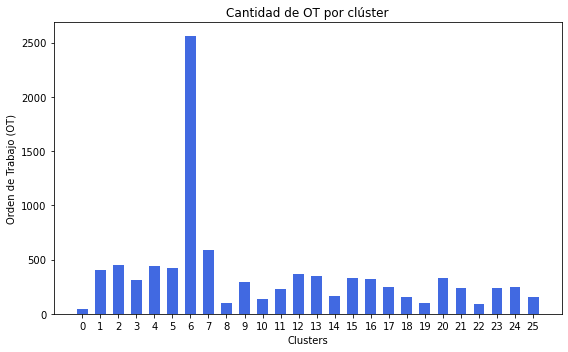

In [55]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Tipo de Falla', nro_top=1) 

## Más pruebas con estaciones

### Estación con más de 100 sentences 

In [56]:
# SELECCIONANDO UNA ESTACIÓN ('Inversiones Enex')
df = df_total[df_total['Estacion'] == 'Inversiones Enex'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

195

Número óptimo de clústers: 22


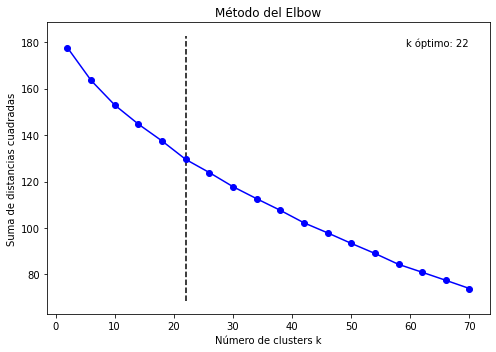

Wall time: 8.21 s


In [57]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Estación', nro_top=3)

Wall time: 3.97 s


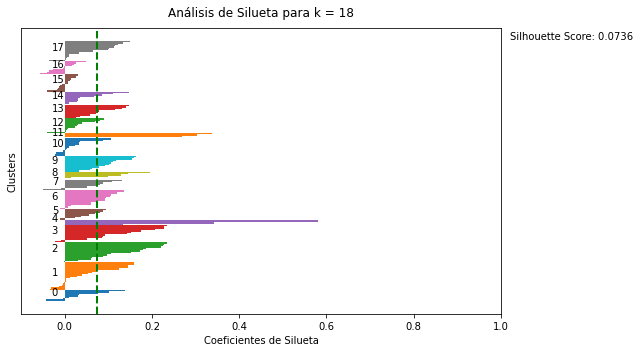

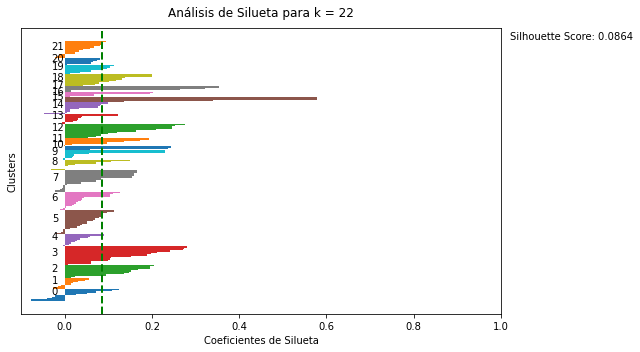

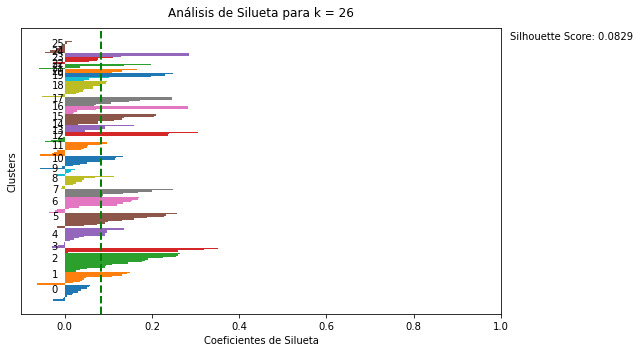

In [58]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[18,22,26], name='Estacion 3', save=True)

In [59]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza el cambio de 1 manguera de 34 x 32 metros en boca nro 15 gas 95 por encontrarse rota y filtrando se recircula producto quedando operativo se realiza el cambio de 1 manguera de 34 x 32 metros en boca nro 15 gas 95 por encontrarse rota y filtrando se recircula producto quedando operativo
	sentence  0 :  se solicita 02 fundas negras 1 por falta de stock en bodega movil para equipos de alto galonaje por encontrarse rotas
	sentence  1 :  se realiza cambio de 1 manguera de 34 x 32 mts a la boca n13 producto pdiesel por encontrarse rota quedando operativo se realiza cambio de 1 manguera de 34 x 32 mts a la boca n13 producto pdiesel por encontrarse rota quedando operativo
	sentence  2 :  cambio de 02 fundas de 1 en dispensador 4 por encontrarse rotas cambio de 02 fundas de 1 en dispensador 4 por encontrarse rotas
	sentence  3 :  se realiza revision de dispensador por falla al inicio de un despacho la falla corresponde al ortr que tiene la mica rota causando qu

In [60]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza el cambio de 1 manguera de 34 x 32 metros en boca nro 15 gas 95 por encontrarse rota y filtrando se recircula producto quedando operativo se realiza el cambio de 1 manguera de 34 x 32 metros en boca nro 15 gas 95 por encontrarse rota y filtrando se recircula producto quedando operativo
Cluster  1 : cambio oring 12 opw tk4 por encontrarse partido instalacion oring 12 opw tk2 por ausencia cambio de 02 filtros baja capacidad cambio 01 funda 1 negra por encontrarse rota cambio 01 pistola 1 por falla en corte automatico serie 90004 en disp1 cambio de 03 filtros alta capacidad cambio 02 fundas negras 12 por encontrarse rotas cambio de 03 filtros alta capacidad 02 fundas verdes 01 funda roja 01 acoplamiento fusible seguridad por encontrarse con enganche fracturado chequeo y calibracion disp 1 2 y 3 cambio de 01 funda 12 negra disp3 cambio 02 filtros alta capacidad 01 funda 12 negra 01 funda verde y 01 wipehose 34 por poseer malla metalica expuesta en disp4 cambio 02 fi

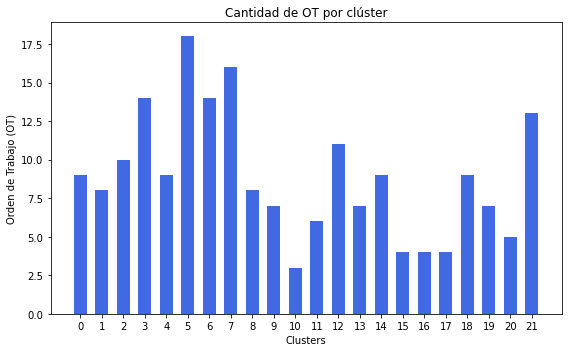

In [61]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Estación', nro_top=3) 

### Estación con un número de senteces entre 30 y 70

In [62]:
# SELECCIONANDO UNA ESTACIÓN ('LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.')
df = df_total[df_total['Estacion'] == 'LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

52

Número óptimo de clústers: 24


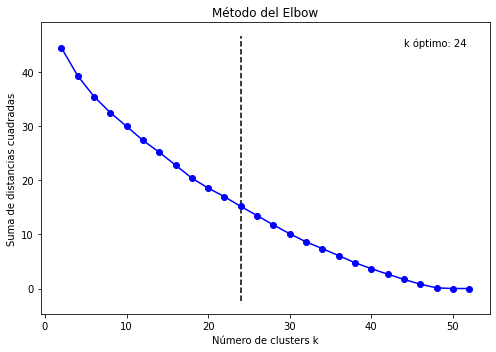

Wall time: 10.2 s


In [63]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = True, namecol='Estación', nro_top='Llanos 30-70')

Wall time: 3.35 s


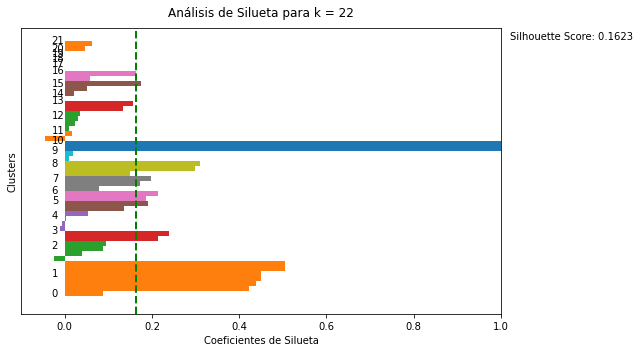

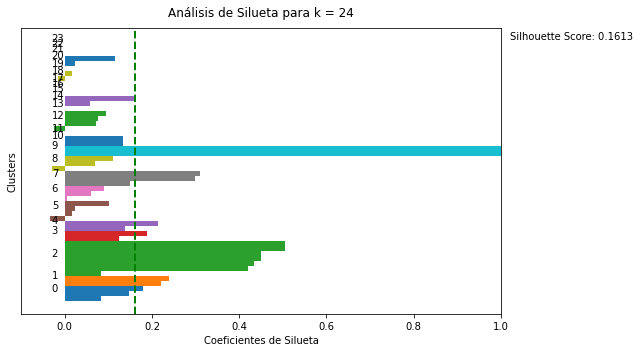

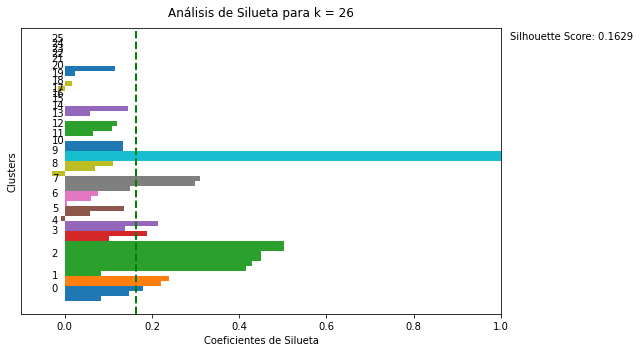

In [67]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[22,24,26], name='Estacion Llanos 30-70', save=True)

In [68]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=24
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : incidencia fue atendida bajo la ot 4 por tecnico gonzalo barria
	sentence  0 :  incidencia duplicada se cerro bajo os 101034
	sentence  1 :  incidencia fue atendida bajo la ot 4 por tecnico gonzalo barria
	sentence  2 :  ods atendida bajo ot 7
Cluster 1 : se visita eds para chequeo de dispensador el cual arroja codigo de error 20 se procede a retirar y a limpiar su pulser el cual se encuentra con presencia de sulfato y humedad en su interior se instalan y se procede a recircular producto para ver su funcionamiento el cual queda despachado producto de forma normal otcerrada se visita eds para chequeo de dispensador el cual arroja codigo de error 20 se procede a retirar y a limpiar su pulser el cual se encuentra con presencia de sulfato y humedad en su interior se instalan y se procede a recircular producto para ver su funcionamiento el cual queda despachado producto de forma normal otcerrada
	sentence  0 :  se visita eds para chequeo de dispensador el cual arroja 

In [69]:
# Clusters representativos (con n = 24)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : incidencia fue atendida bajo la ot 4 por tecnico gonzalo barria
Cluster  1 : se visita eds para chequeo de dispensador el cual arroja codigo de error 20 se procede a retirar y a limpiar su pulser el cual se encuentra con presencia de sulfato y humedad en su interior se instalan y se procede a recircular producto para ver su funcionamiento el cual queda despachado producto de forma normal otcerrada se visita eds para chequeo de dispensador el cual arroja codigo de error 20 se procede a retirar y a limpiar su pulser el cual se encuentra con presencia de sulfato y humedad en su interior se instalan y se procede a recircular producto para ver su funcionamiento el cual queda despachado producto de forma normal otcerrada
Cluster  2 : se realiza visita a estacion de servicio para efectuar mantenimiento preventivo calendarizado por enex chequeando la calibracion de 8 bocas se prueban valvulas de impacto las cuales estan operativas se cambian 03 filtros en lineas gas 93 gas 95 y ga

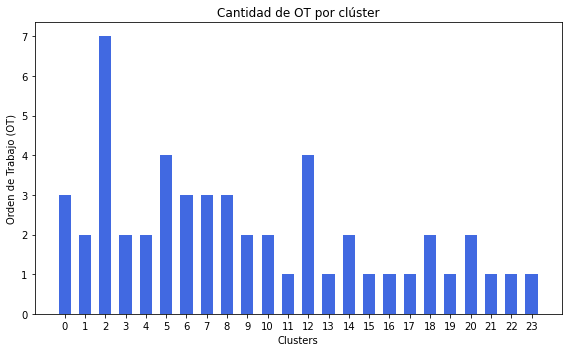

In [70]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = True, namecol='Estación', nro_top='Llanos 30-70') 

### Estación con menos de 30 sentences

In [71]:
# SELECCIONANDO UNA ESTACIÓN ('Sociedad Comercial Fariña Y Cia. Ltda.')
df = df_total[df_total['Estacion'] == 'Sociedad Comercial Fariña Y Cia. Ltda.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

16

Número óptimo de clústers: 7


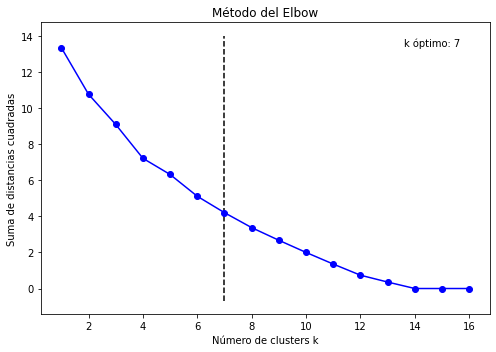

Wall time: 4.14 s


In [72]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,  save = True, namecol='Estación', nro_top='Fariña  Menos 30')

Wall time: 1.24 s


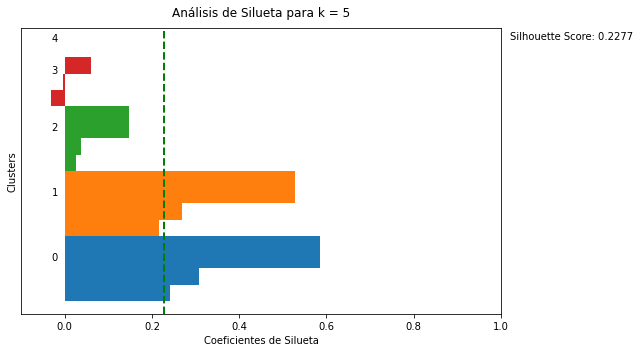

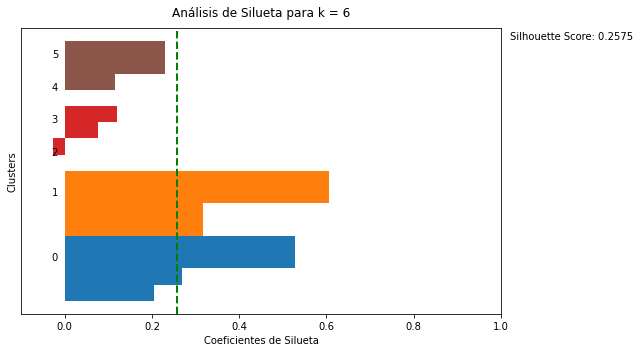

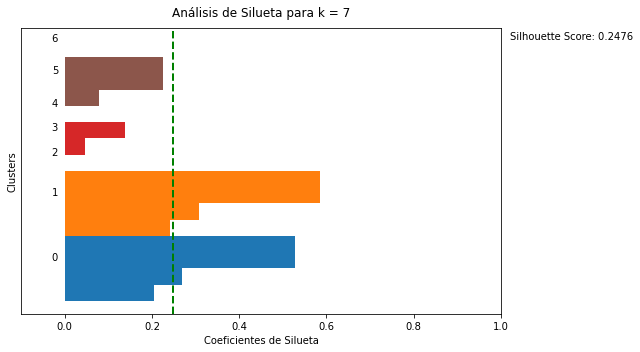

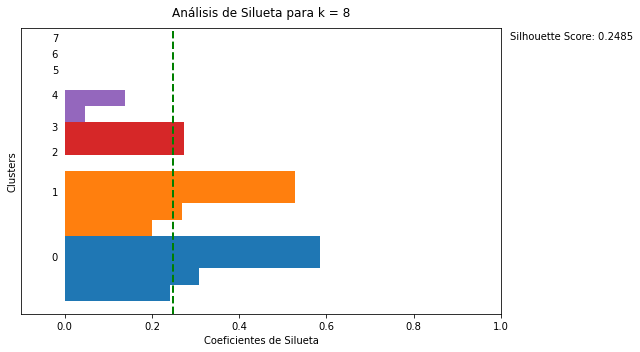

In [74]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta
silhouette_analysis(sentences, n_clusters=[5,6,7,8], name='Estacion Fariña  Menos 30', save=True)

In [75]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=6
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os numero 105957 y ot numero 0
	sentence  0 :  incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os numero 105957 y ot numero 0
	sentence  1 :  incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os numero 105957 y ot numero 0
	sentence  2 :  se cierra bajo la ot 0
	sentence  3 :  incidencia es atendida bajo ot 1
Cluster 1 : mantencion preventiva se calibran 16 bocas se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia oring de valvula mezcladora en mal estado de post4 g97 producto recirculado devuelto a tk correspondiente equipos quedan operativos se chequea tdf y tks mantencion preventiva se calibran 16 bocas se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia oring de valvula mezcl

In [76]:
# Clusters representativos (con n = 6)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os numero 105957 y ot numero 0
Cluster  1 : mantencion preventiva se calibran 16 bocas se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia oring de valvula mezcladora en mal estado de post4 g97 producto recirculado devuelto a tk correspondiente equipos quedan operativos se chequea tdf y tks mantencion preventiva se calibran 16 bocas se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia oring de valvula mezcladora en mal estado de post4 g97 producto recirculado devuelto a tk correspondiente equipos quedan operativos se chequea tdf y tks
Cluster  2 : no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene no se puede cambiar detector de fuga ya que el unico equi

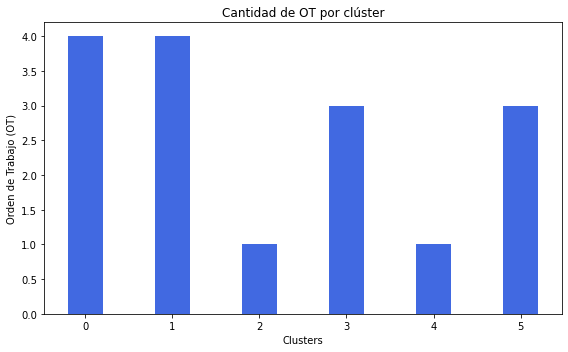

In [77]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters,width=0.4, save = True, namecol='Estación', nro_top='Fariña  Menos 30') 

### En el caso que tenga solo 2 sentences

In [78]:
# SELECCIONANDO UNA ESTACIÓN ('GEOTERMICA DEL NORTE S.A')
df = df_total[df_total['Estacion'] == 'GEOTERMICA DEL NORTE S.A'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

2

Número óptimo de clústers: None


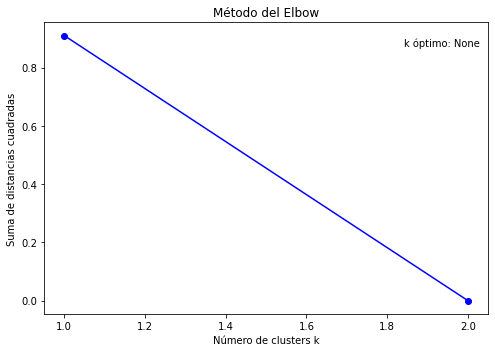

Wall time: 834 ms


In [79]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

### En el caso que tenga solo 1 sentence

In [80]:
# SELECCIONANDO UNA ESTACIÓN ('Santa Laura - San Bernardo')
df = df_total[df_total['Estacion'] == 'Santa Laura - San Bernardo'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1

In [81]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

You must enter at least two sentences
Wall time: 598 ms
